# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 3.1816416663794853 -3.0193599502854744
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [35]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [36]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [37]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [60]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [61]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [62]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [63]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [64]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [65]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [66]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:56.0000 rate:0.1120 gloss:0.0931 dloss:0.7044 dlossR:0.7044 dlossQ:0.6923
Episode:1 meanR:96.0000 rate:0.2720 gloss:0.1720 dloss:0.6897 dlossR:0.6897 dlossQ:0.6942
Episode:2 meanR:88.6667 rate:0.1480 gloss:0.0852 dloss:0.6857 dlossR:0.6857 dlossQ:0.6938
Episode:3 meanR:91.5000 rate:0.2000 gloss:0.0936 dloss:0.6758 dlossR:0.6758 dlossQ:0.6954
Episode:4 meanR:90.8000 rate:0.1760 gloss:0.0425 dloss:0.6594 dlossR:0.6594 dlossQ:0.6956
Episode:5 meanR:92.1667 rate:0.1980 gloss:0.0242 dloss:0.6498 dlossR:0.6498 dlossQ:0.6958
Episode:6 meanR:91.5714 rate:0.1760 gloss:-0.0572 dloss:0.6217 dlossR:0.6217 dlossQ:0.6915
Episode:7 meanR:85.1250 rate:0.0800 gloss:-0.0204 dloss:0.6473 dlossR:0.6473 dlossQ:0.6940
Episode:8 meanR:81.5556 rate:0.1060 gloss:-0.0162 dloss:0.6431 dlossR:0.6431 dlossQ:0.6946
Episode:9 meanR:78.0000 rate:0.0920 gloss:-0.0416 dloss:0.6314 dlossR:0.6314 dlossQ:0.6938
Episode:10 meanR:73.7273 rate:0.0620 gloss:-0.0751 dloss:0.6174 dlossR:0.6174 dlossQ:0.6921
Epis

Episode:98 meanR:49.9697 rate:0.0200 gloss:-1.9579 dloss:0.1167 dlossR:0.1167 dlossQ:0.3635
Episode:99 meanR:49.5600 rate:0.0180 gloss:-1.7374 dloss:0.1217 dlossR:0.1217 dlossQ:0.4298
Episode:100 meanR:49.0900 rate:0.0180 gloss:-1.8890 dloss:0.1129 dlossR:0.1129 dlossQ:0.3674
Episode:101 meanR:47.8100 rate:0.0160 gloss:-1.6409 dloss:0.1212 dlossR:0.1212 dlossQ:0.4529
Episode:102 meanR:47.2100 rate:0.0280 gloss:-1.4726 dloss:0.1602 dlossR:0.1602 dlossQ:0.3878
Episode:103 meanR:46.6600 rate:0.0900 gloss:-1.4136 dloss:0.3052 dlossR:0.3052 dlossQ:0.3762
Episode:104 meanR:46.3500 rate:0.1140 gloss:-1.3933 dloss:0.3568 dlossR:0.3568 dlossQ:0.3744
Episode:105 meanR:45.6700 rate:0.0620 gloss:-1.4219 dloss:0.2445 dlossR:0.2445 dlossQ:0.3821
Episode:106 meanR:45.5400 rate:0.1500 gloss:-1.4098 dloss:0.4385 dlossR:0.4385 dlossQ:0.3681
Episode:107 meanR:45.4100 rate:0.0540 gloss:-1.4331 dloss:0.2267 dlossR:0.2267 dlossQ:0.3830
Episode:108 meanR:45.7600 rate:0.1760 gloss:-1.4061 dloss:0.4989 dlossR:

Episode:187 meanR:37.1500 rate:0.0600 gloss:-1.6608 dloss:0.2453 dlossR:0.2453 dlossQ:0.3677
Episode:188 meanR:36.9600 rate:0.1180 gloss:-1.3821 dloss:0.3679 dlossR:0.3679 dlossQ:0.3803
Episode:189 meanR:37.6000 rate:0.2580 gloss:-1.2725 dloss:0.6667 dlossR:0.6667 dlossQ:0.4166
Episode:190 meanR:39.0200 rate:0.3720 gloss:-1.1274 dloss:0.8827 dlossR:0.8827 dlossQ:0.4628
Episode:191 meanR:40.8800 rate:0.4100 gloss:-1.0968 dloss:0.9578 dlossR:0.9578 dlossQ:0.4737
Episode:192 meanR:42.7400 rate:0.4100 gloss:-1.0161 dloss:0.9230 dlossR:0.9230 dlossQ:0.4987
Episode:193 meanR:44.3300 rate:0.3460 gloss:-1.0123 dloss:0.7859 dlossR:0.7859 dlossQ:0.4972
Episode:194 meanR:45.4300 rate:0.2540 gloss:-1.0002 dloss:0.6049 dlossR:0.6049 dlossQ:0.4968
Episode:195 meanR:45.9700 rate:0.1420 gloss:-1.0568 dloss:0.4115 dlossR:0.4115 dlossQ:0.4768
Episode:196 meanR:47.1200 rate:0.2560 gloss:-0.9363 dloss:0.6000 dlossR:0.6000 dlossQ:0.5176
Episode:197 meanR:47.7300 rate:0.1460 gloss:-0.9927 dloss:0.4203 dloss

Episode:279 meanR:45.8400 rate:0.3940 gloss:-1.3168 dloss:1.0120 dlossR:1.0120 dlossQ:0.3973
Episode:280 meanR:46.8300 rate:0.2260 gloss:-1.6216 dloss:0.6631 dlossR:0.6631 dlossQ:0.3088
Episode:281 meanR:47.4100 rate:0.1980 gloss:-1.6312 dloss:0.5887 dlossR:0.5887 dlossQ:0.3064
Episode:282 meanR:48.1400 rate:0.1760 gloss:-1.6487 dloss:0.5324 dlossR:0.5324 dlossQ:0.3026
Episode:283 meanR:48.9700 rate:0.1900 gloss:-1.5865 dloss:0.5604 dlossR:0.5604 dlossQ:0.3194
Episode:284 meanR:49.5500 rate:0.1340 gloss:-1.6509 dloss:0.4213 dlossR:0.4213 dlossQ:0.3048
Episode:285 meanR:50.1800 rate:0.1460 gloss:-1.6206 dloss:0.4503 dlossR:0.4503 dlossQ:0.3131
Episode:286 meanR:50.2900 rate:0.0540 gloss:-1.4808 dloss:0.2210 dlossR:0.2210 dlossQ:0.3586
Episode:287 meanR:50.2300 rate:0.0480 gloss:-1.4801 dloss:0.2098 dlossR:0.2098 dlossQ:0.3830
Episode:288 meanR:49.8100 rate:0.0340 gloss:-1.5347 dloss:0.1733 dlossR:0.1733 dlossQ:0.3881
Episode:289 meanR:48.7900 rate:0.0540 gloss:-1.4516 dloss:0.2244 dloss

Episode:373 meanR:55.5500 rate:0.0380 gloss:-1.7870 dloss:0.1721 dlossR:0.1721 dlossQ:0.3180
Episode:374 meanR:55.6600 rate:0.0440 gloss:-1.7441 dloss:0.1920 dlossR:0.1920 dlossQ:0.3503
Episode:375 meanR:55.8600 rate:0.0740 gloss:-1.7283 dloss:0.2687 dlossR:0.2687 dlossQ:0.3049
Episode:376 meanR:57.4200 rate:0.3280 gloss:-1.6501 dloss:0.9707 dlossR:0.9707 dlossQ:0.3084
Episode:377 meanR:57.9600 rate:0.1340 gloss:-1.4801 dloss:0.4072 dlossR:0.4072 dlossQ:0.3561
Episode:378 meanR:60.1800 rate:0.5480 gloss:-1.2849 dloss:1.4239 dlossR:1.4239 dlossQ:0.4204
Episode:379 meanR:59.4900 rate:0.2560 gloss:-1.5725 dloss:0.7389 dlossR:0.7389 dlossQ:0.3286
Episode:380 meanR:59.5300 rate:0.2340 gloss:-1.5260 dloss:0.6680 dlossR:0.6680 dlossQ:0.3403
Episode:381 meanR:59.4600 rate:0.1840 gloss:-1.5175 dloss:0.5388 dlossR:0.5388 dlossQ:0.3430
Episode:382 meanR:59.6400 rate:0.2120 gloss:-1.4199 dloss:0.5926 dlossR:0.5926 dlossQ:0.3715
Episode:383 meanR:59.0200 rate:0.0660 gloss:-1.2429 dloss:0.2640 dloss

Episode:463 meanR:50.7600 rate:0.1660 gloss:-1.2036 dloss:0.4625 dlossR:0.4625 dlossQ:0.4337
Episode:464 meanR:51.2000 rate:0.2300 gloss:-1.1832 dloss:0.5872 dlossR:0.5872 dlossQ:0.4404
Episode:465 meanR:50.8100 rate:0.1300 gloss:-1.1513 dloss:0.3893 dlossR:0.3893 dlossQ:0.4559
Episode:466 meanR:51.4600 rate:0.1800 gloss:-1.1537 dloss:0.4828 dlossR:0.4828 dlossQ:0.4477
Episode:467 meanR:51.7700 rate:0.1020 gloss:-1.1707 dloss:0.3380 dlossR:0.3380 dlossQ:0.4523
Episode:468 meanR:52.5000 rate:0.2400 gloss:-1.1035 dloss:0.5936 dlossR:0.5936 dlossQ:0.4650
Episode:469 meanR:53.3400 rate:0.2080 gloss:-1.1789 dloss:0.5428 dlossR:0.5428 dlossQ:0.4408
Episode:470 meanR:53.1500 rate:0.0220 gloss:-1.6403 dloss:0.1420 dlossR:0.1420 dlossQ:0.3877
Episode:471 meanR:53.6400 rate:0.1560 gloss:-1.1300 dloss:0.4405 dlossR:0.4405 dlossQ:0.4685
Episode:472 meanR:53.8500 rate:0.0860 gloss:-1.1898 dloss:0.3170 dlossR:0.3170 dlossQ:0.4589
Episode:473 meanR:54.2400 rate:0.1160 gloss:-1.1965 dloss:0.3697 dloss

Episode:552 meanR:85.7500 rate:0.1460 gloss:-0.6988 dloss:0.4428 dlossR:0.4428 dlossQ:0.5853
Episode:553 meanR:85.9300 rate:0.1640 gloss:-0.7305 dloss:0.4590 dlossR:0.4590 dlossQ:0.5772
Episode:554 meanR:86.0300 rate:0.1620 gloss:-0.7841 dloss:0.4523 dlossR:0.4523 dlossQ:0.5606
Episode:555 meanR:86.3500 rate:0.2200 gloss:-0.7181 dloss:0.5283 dlossR:0.5283 dlossQ:0.5817
Episode:556 meanR:86.3900 rate:0.2620 gloss:-0.7565 dloss:0.5873 dlossR:0.5873 dlossQ:0.5727
Episode:557 meanR:87.0200 rate:0.2580 gloss:-0.8023 dloss:0.5934 dlossR:0.5934 dlossQ:0.5627
Episode:558 meanR:86.8100 rate:0.0660 gloss:-0.9830 dloss:0.3041 dlossR:0.3041 dlossQ:0.5138
Episode:559 meanR:87.5700 rate:0.1940 gloss:-0.8206 dloss:0.4943 dlossR:0.4943 dlossQ:0.5507
Episode:560 meanR:88.0000 rate:0.1220 gloss:-0.8963 dloss:0.3891 dlossR:0.3891 dlossQ:0.5262
Episode:561 meanR:88.5600 rate:0.1740 gloss:-0.8105 dloss:0.4678 dlossR:0.4678 dlossQ:0.5529
Episode:562 meanR:88.4700 rate:0.0900 gloss:-0.9142 dloss:0.3428 dloss

Episode:648 meanR:43.0800 rate:0.0560 gloss:-2.1148 dloss:0.2269 dlossR:0.2269 dlossQ:0.2478
Episode:649 meanR:42.8000 rate:0.0200 gloss:-2.4760 dloss:0.1072 dlossR:0.1072 dlossQ:0.3444
Episode:650 meanR:42.6000 rate:0.0460 gloss:-2.2146 dloss:0.1987 dlossR:0.1987 dlossQ:0.2549
Episode:651 meanR:41.9400 rate:0.0260 gloss:-1.9736 dloss:0.1295 dlossR:0.1295 dlossQ:0.3296
Episode:652 meanR:41.3400 rate:0.0260 gloss:-2.0033 dloss:0.1283 dlossR:0.1283 dlossQ:0.3221
Episode:653 meanR:40.7000 rate:0.0360 gloss:-2.2028 dloss:0.1660 dlossR:0.1660 dlossQ:0.2962
Episode:654 meanR:39.9900 rate:0.0200 gloss:-2.4248 dloss:0.1055 dlossR:0.1055 dlossQ:0.3467
Episode:655 meanR:39.5000 rate:0.1220 gloss:-1.9040 dloss:0.4170 dlossR:0.4170 dlossQ:0.2714
Episode:656 meanR:38.4400 rate:0.0500 gloss:-1.8246 dloss:0.2005 dlossR:0.2005 dlossQ:0.2927
Episode:657 meanR:37.3900 rate:0.0480 gloss:-1.8148 dloss:0.1947 dlossR:0.1947 dlossQ:0.2917
Episode:658 meanR:37.2500 rate:0.0380 gloss:-1.9725 dloss:0.1636 dloss

Episode:738 meanR:47.9200 rate:0.0360 gloss:-1.3645 dloss:0.1920 dlossR:0.1920 dlossQ:0.3901
Episode:739 meanR:47.7700 rate:0.0220 gloss:-1.5754 dloss:0.1384 dlossR:0.1384 dlossQ:0.3869
Episode:740 meanR:47.7400 rate:0.0260 gloss:-1.6324 dloss:0.1451 dlossR:0.1451 dlossQ:0.3633
Episode:741 meanR:47.6900 rate:0.0280 gloss:-1.6036 dloss:0.1522 dlossR:0.1522 dlossQ:0.3545
Episode:742 meanR:47.6400 rate:0.0200 gloss:-1.6339 dloss:0.1285 dlossR:0.1285 dlossQ:0.3739
Episode:743 meanR:47.6100 rate:0.0300 gloss:-1.5941 dloss:0.1577 dlossR:0.1577 dlossQ:0.3697
Episode:744 meanR:47.8400 rate:0.0740 gloss:-1.3134 dloss:0.2771 dlossR:0.2771 dlossQ:0.4067
Episode:745 meanR:48.3400 rate:0.1240 gloss:-1.2684 dloss:0.3773 dlossR:0.3773 dlossQ:0.4127
Episode:746 meanR:48.8700 rate:0.1280 gloss:-1.3910 dloss:0.3914 dlossR:0.3914 dlossQ:0.3807
Episode:747 meanR:49.5200 rate:0.1940 gloss:-1.2772 dloss:0.5234 dlossR:0.5234 dlossQ:0.4074
Episode:748 meanR:50.8900 rate:0.3300 gloss:-1.2611 dloss:0.8322 dloss

Episode:827 meanR:72.5200 rate:0.2440 gloss:-1.2648 dloss:0.6314 dlossR:0.6314 dlossQ:0.4188
Episode:828 meanR:75.0200 rate:0.5300 gloss:-0.3551 dloss:0.8912 dlossR:0.8912 dlossQ:0.6661
Episode:829 meanR:76.8200 rate:0.3820 gloss:-0.5135 dloss:0.7562 dlossR:0.7562 dlossQ:0.6137
Episode:830 meanR:77.3200 rate:0.1360 gloss:-1.2260 dloss:0.4027 dlossR:0.4027 dlossQ:0.4300
Episode:831 meanR:77.5600 rate:0.0880 gloss:-1.2114 dloss:0.3103 dlossR:0.3103 dlossQ:0.4260
Episode:832 meanR:77.4400 rate:0.0580 gloss:-1.3890 dloss:0.2364 dlossR:0.2364 dlossQ:0.3786
Episode:833 meanR:76.4400 rate:0.0600 gloss:-1.4956 dloss:0.2344 dlossR:0.2344 dlossQ:0.3511
Episode:834 meanR:75.7200 rate:0.0520 gloss:-1.4654 dloss:0.2184 dlossR:0.2184 dlossQ:0.3598
Episode:835 meanR:75.0300 rate:0.0400 gloss:-1.4917 dloss:0.1887 dlossR:0.1887 dlossQ:0.3677
Episode:836 meanR:74.4400 rate:0.0320 gloss:-1.6072 dloss:0.1609 dlossR:0.1609 dlossQ:0.3480
Episode:837 meanR:74.0700 rate:0.0340 gloss:-1.7049 dloss:0.1612 dloss

Episode:916 meanR:82.5500 rate:0.2520 gloss:-0.2836 dloss:0.5949 dlossR:0.5949 dlossQ:0.6746
Episode:917 meanR:83.7000 rate:0.3380 gloss:-0.2684 dloss:0.6612 dlossR:0.6612 dlossQ:0.6725
Episode:918 meanR:84.5200 rate:0.2860 gloss:-0.2907 dloss:0.6161 dlossR:0.6161 dlossQ:0.6747
Episode:919 meanR:85.6200 rate:0.3400 gloss:-0.2802 dloss:0.6550 dlossR:0.6550 dlossQ:0.6797
Episode:920 meanR:87.0100 rate:0.3960 gloss:-0.3303 dloss:0.7123 dlossR:0.7123 dlossQ:0.6726
Episode:921 meanR:88.5300 rate:0.3980 gloss:-0.3072 dloss:0.7090 dlossR:0.7090 dlossQ:0.6778
Episode:922 meanR:90.8000 rate:0.5260 gloss:-0.3238 dloss:0.8565 dlossR:0.8565 dlossQ:0.6882
Episode:923 meanR:93.0800 rate:0.4980 gloss:-0.2750 dloss:0.8044 dlossR:0.8044 dlossQ:0.6946
Episode:924 meanR:97.5200 rate:0.9660 gloss:-0.0494 dloss:1.3258 dlossR:1.3258 dlossQ:0.7933
Episode:925 meanR:99.7100 rate:0.5180 gloss:-0.1511 dloss:0.7873 dlossR:0.7873 dlossQ:0.7090
Episode:926 meanR:99.5600 rate:0.0260 gloss:-0.9963 dloss:0.2356 dloss

Episode:1006 meanR:161.7600 rate:0.8520 gloss:0.5276 dloss:0.7451 dlossR:0.7451 dlossQ:0.6966
Episode:1007 meanR:165.4600 rate:1.0000 gloss:0.3426 dloss:0.9955 dlossR:0.9955 dlossQ:0.7724
Episode:1008 meanR:169.3500 rate:1.0000 gloss:0.3562 dloss:0.9775 dlossR:0.9775 dlossQ:0.7771
Episode:1009 meanR:171.6300 rate:0.6860 gloss:-0.0438 dloss:0.9312 dlossR:0.9312 dlossQ:0.7229
Episode:1010 meanR:171.6200 rate:0.2080 gloss:-0.7095 dloss:0.5275 dlossR:0.5275 dlossQ:0.5808
Episode:1011 meanR:171.4400 rate:0.2160 gloss:-0.6816 dloss:0.5419 dlossR:0.5419 dlossQ:0.5906
Episode:1012 meanR:171.4700 rate:0.1920 gloss:-0.7225 dloss:0.5035 dlossR:0.5035 dlossQ:0.5780
Episode:1013 meanR:170.7400 rate:0.1480 gloss:-0.7000 dloss:0.4538 dlossR:0.4538 dlossQ:0.5859
Episode:1014 meanR:170.1800 rate:0.1280 gloss:-0.6734 dloss:0.4413 dlossR:0.4413 dlossQ:0.5920
Episode:1015 meanR:169.1800 rate:0.1120 gloss:-0.6714 dloss:0.4270 dlossR:0.4270 dlossQ:0.5931
Episode:1016 meanR:168.1900 rate:0.0540 gloss:-0.5825

Episode:1093 meanR:160.0400 rate:0.5180 gloss:0.3124 dloss:0.7163 dlossR:0.7163 dlossQ:0.6826
Episode:1094 meanR:161.8800 rate:0.5080 gloss:0.3431 dloss:0.7026 dlossR:0.7026 dlossQ:0.6877
Episode:1095 meanR:163.7000 rate:0.5120 gloss:0.2398 dloss:0.7165 dlossR:0.7165 dlossQ:0.6958
Episode:1096 meanR:164.6500 rate:0.2100 gloss:0.0017 dloss:0.6800 dlossR:0.6800 dlossQ:0.6604
Episode:1097 meanR:166.6300 rate:0.5680 gloss:0.3479 dloss:0.7222 dlossR:0.7222 dlossQ:0.6802
Episode:1098 meanR:164.4600 rate:0.5660 gloss:0.2917 dloss:0.7228 dlossR:0.7228 dlossQ:0.6952
Episode:1099 meanR:162.3500 rate:0.5780 gloss:0.3667 dloss:0.7177 dlossR:0.7177 dlossQ:0.6812
Episode:1100 meanR:160.6200 rate:0.4760 gloss:0.3880 dloss:0.7134 dlossR:0.7134 dlossQ:0.6691
Episode:1101 meanR:160.7400 rate:0.5780 gloss:0.3962 dloss:0.7057 dlossR:0.7057 dlossQ:0.6835
Episode:1102 meanR:163.7200 rate:0.6620 gloss:0.5003 dloss:0.6966 dlossR:0.6966 dlossQ:0.6721
Episode:1103 meanR:165.6600 rate:0.4240 gloss:0.3694 dloss:0

Episode:1180 meanR:209.1400 rate:0.2160 gloss:0.0363 dloss:0.6552 dlossR:0.6552 dlossQ:0.6948
Episode:1181 meanR:206.0800 rate:0.2660 gloss:-0.0926 dloss:0.6330 dlossR:0.6330 dlossQ:0.6876
Episode:1182 meanR:204.1600 rate:0.2320 gloss:-0.1633 dloss:0.6037 dlossR:0.6037 dlossQ:0.6847
Episode:1183 meanR:201.9900 rate:0.1700 gloss:-0.1768 dloss:0.5757 dlossR:0.5757 dlossQ:0.6870
Episode:1184 meanR:199.8700 rate:0.1140 gloss:-0.4137 dloss:0.4794 dlossR:0.4794 dlossQ:0.6511
Episode:1185 meanR:197.7500 rate:0.0700 gloss:-0.6430 dloss:0.3808 dlossR:0.3808 dlossQ:0.5985
Episode:1186 meanR:195.3900 rate:0.0520 gloss:-0.7556 dloss:0.3309 dlossR:0.3309 dlossQ:0.5719
Episode:1187 meanR:193.3500 rate:0.0440 gloss:-0.6854 dloss:0.3424 dlossR:0.3424 dlossQ:0.5905
Episode:1188 meanR:191.0400 rate:0.0600 gloss:-0.5995 dloss:0.3840 dlossR:0.3840 dlossQ:0.6110
Episode:1189 meanR:188.7500 rate:0.0340 gloss:-0.8143 dloss:0.2931 dlossR:0.2931 dlossQ:0.5565
Episode:1190 meanR:185.9100 rate:0.0280 gloss:-0.90

Episode:1270 meanR:59.6000 rate:0.1360 gloss:-1.2879 dloss:0.4082 dlossR:0.4082 dlossQ:0.4306
Episode:1271 meanR:60.0500 rate:0.3580 gloss:-0.5849 dloss:0.7039 dlossR:0.7039 dlossQ:0.6230
Episode:1272 meanR:59.5600 rate:0.1920 gloss:-1.2472 dloss:0.5214 dlossR:0.5214 dlossQ:0.4396
Episode:1273 meanR:59.8200 rate:0.2740 gloss:-0.8022 dloss:0.6165 dlossR:0.6165 dlossQ:0.5566
Episode:1274 meanR:58.8900 rate:0.1600 gloss:-1.0414 dloss:0.4426 dlossR:0.4426 dlossQ:0.4811
Episode:1275 meanR:57.8100 rate:0.1220 gloss:-1.1832 dloss:0.3725 dlossR:0.3725 dlossQ:0.4391
Episode:1276 meanR:57.1400 rate:0.1180 gloss:-1.3143 dloss:0.3642 dlossR:0.3642 dlossQ:0.4005
Episode:1277 meanR:55.7700 rate:0.0580 gloss:-1.3744 dloss:0.2380 dlossR:0.2380 dlossQ:0.3883
Episode:1278 meanR:54.4500 rate:0.0420 gloss:-1.4415 dloss:0.1985 dlossR:0.1985 dlossQ:0.3838
Episode:1279 meanR:53.4500 rate:0.0400 gloss:-1.5288 dloss:0.1875 dlossR:0.1875 dlossQ:0.3531
Episode:1280 meanR:52.5600 rate:0.0380 gloss:-1.5955 dloss:0

Episode:1358 meanR:62.3800 rate:0.3200 gloss:-1.1721 dloss:0.7838 dlossR:0.7838 dlossQ:0.4494
Episode:1359 meanR:62.3700 rate:0.0260 gloss:-1.8724 dloss:0.1448 dlossR:0.1448 dlossQ:0.3656
Episode:1360 meanR:62.3100 rate:0.0240 gloss:-1.8747 dloss:0.1382 dlossR:0.1382 dlossQ:0.3603
Episode:1361 meanR:62.7600 rate:0.1260 gloss:-1.4798 dloss:0.3920 dlossR:0.3920 dlossQ:0.3593
Episode:1362 meanR:63.5200 rate:0.1760 gloss:-1.4263 dloss:0.5042 dlossR:0.5042 dlossQ:0.3733
Episode:1363 meanR:65.1000 rate:0.3380 gloss:-0.6858 dloss:0.6999 dlossR:0.6999 dlossQ:0.5930
Episode:1364 meanR:68.1200 rate:0.6300 gloss:-0.8142 dloss:1.3156 dlossR:1.3156 dlossQ:0.5764
Episode:1365 meanR:68.7300 rate:0.1580 gloss:-1.2309 dloss:0.4476 dlossR:0.4476 dlossQ:0.4281
Episode:1366 meanR:68.9100 rate:0.1200 gloss:-1.2899 dloss:0.3725 dlossR:0.3725 dlossQ:0.4094
Episode:1367 meanR:68.6400 rate:0.0220 gloss:-1.6281 dloss:0.1427 dlossR:0.1427 dlossQ:0.3866
Episode:1368 meanR:68.3500 rate:0.0440 gloss:-1.4559 dloss:0

Episode:1447 meanR:81.4600 rate:0.1480 gloss:-1.2438 dloss:0.4266 dlossR:0.4266 dlossQ:0.4246
Episode:1448 meanR:81.3300 rate:0.1200 gloss:-1.2299 dloss:0.3700 dlossR:0.3700 dlossQ:0.4276
Episode:1449 meanR:80.7100 rate:0.0220 gloss:-1.6166 dloss:0.1445 dlossR:0.1445 dlossQ:0.4087
Episode:1450 meanR:80.6200 rate:0.1420 gloss:-1.2264 dloss:0.4141 dlossR:0.4141 dlossQ:0.4303
Episode:1451 meanR:80.6500 rate:0.1580 gloss:-1.2147 dloss:0.4454 dlossR:0.4454 dlossQ:0.4338
Episode:1452 meanR:80.9600 rate:0.1740 gloss:-1.1670 dloss:0.4740 dlossR:0.4740 dlossQ:0.4477
Episode:1453 meanR:80.8900 rate:0.0700 gloss:-1.3249 dloss:0.2681 dlossR:0.2681 dlossQ:0.4061
Episode:1454 meanR:80.7600 rate:0.0260 gloss:-1.4739 dloss:0.1597 dlossR:0.1597 dlossQ:0.3890
Episode:1455 meanR:80.8500 rate:0.0400 gloss:-1.3751 dloss:0.2010 dlossR:0.2010 dlossQ:0.3948
Episode:1456 meanR:80.9300 rate:0.0360 gloss:-1.4337 dloss:0.1866 dlossR:0.1866 dlossQ:0.3814
Episode:1457 meanR:80.9300 rate:0.0220 gloss:-1.5305 dloss:0

Episode:1536 meanR:57.5000 rate:0.1340 gloss:-1.3013 dloss:0.3973 dlossR:0.3973 dlossQ:0.3985
Episode:1537 meanR:57.3100 rate:0.1580 gloss:-1.2945 dloss:0.4468 dlossR:0.4468 dlossQ:0.4005
Episode:1538 meanR:57.6600 rate:0.1800 gloss:-1.2886 dloss:0.4929 dlossR:0.4929 dlossQ:0.4028
Episode:1539 meanR:59.0600 rate:0.3080 gloss:-1.1598 dloss:0.7464 dlossR:0.7464 dlossQ:0.4469
Episode:1540 meanR:59.2800 rate:0.0720 gloss:-1.4565 dloss:0.2632 dlossR:0.2632 dlossQ:0.3650
Episode:1541 meanR:59.5600 rate:0.0840 gloss:-1.4131 dloss:0.2920 dlossR:0.2920 dlossQ:0.3759
Episode:1542 meanR:59.7500 rate:0.0760 gloss:-1.4709 dloss:0.2735 dlossR:0.2735 dlossQ:0.3604
Episode:1543 meanR:60.0400 rate:0.1180 gloss:-1.3997 dloss:0.3674 dlossR:0.3674 dlossQ:0.3789
Episode:1544 meanR:58.6300 rate:0.0520 gloss:-1.5418 dloss:0.2158 dlossR:0.2158 dlossQ:0.3600
Episode:1545 meanR:58.1200 rate:0.0720 gloss:-1.5048 dloss:0.2640 dlossR:0.2640 dlossQ:0.3605
Episode:1546 meanR:57.6400 rate:0.0960 gloss:-1.3204 dloss:0

Episode:1624 meanR:74.2700 rate:0.9240 gloss:-0.1271 dloss:1.3379 dlossR:1.3379 dlossQ:0.7651
Episode:1625 meanR:76.5400 rate:0.4920 gloss:-0.1507 dloss:0.7655 dlossR:0.7655 dlossQ:0.7044
Episode:1626 meanR:76.9800 rate:0.2440 gloss:-1.0076 dloss:0.5945 dlossR:0.5945 dlossQ:0.5065
Episode:1627 meanR:77.7300 rate:0.2200 gloss:-0.9796 dloss:0.5506 dlossR:0.5506 dlossQ:0.5159
Episode:1628 meanR:78.2100 rate:0.1580 gloss:-1.0709 dloss:0.4480 dlossR:0.4480 dlossQ:0.4862
Episode:1629 meanR:78.9300 rate:0.1780 gloss:-1.1037 dloss:0.4863 dlossR:0.4863 dlossQ:0.4760
Episode:1630 meanR:78.9800 rate:0.0440 gloss:-1.1896 dloss:0.2339 dlossR:0.2339 dlossQ:0.4460
Episode:1631 meanR:78.9700 rate:0.0300 gloss:-1.4343 dloss:0.1806 dlossR:0.1806 dlossQ:0.4084
Episode:1632 meanR:78.8300 rate:0.0220 gloss:-1.5044 dloss:0.1559 dlossR:0.1559 dlossQ:0.4150
Episode:1633 meanR:78.7000 rate:0.0220 gloss:-1.4070 dloss:0.1674 dlossR:0.1674 dlossQ:0.4340
Episode:1634 meanR:78.7900 rate:0.0620 gloss:-0.9678 dloss:0

Episode:1711 meanR:152.7600 rate:0.5340 gloss:0.2522 dloss:0.7125 dlossR:0.7125 dlossQ:0.7039
Episode:1712 meanR:155.5800 rate:0.5920 gloss:0.2955 dloss:0.7222 dlossR:0.7222 dlossQ:0.7053
Episode:1713 meanR:158.6600 rate:0.6380 gloss:0.3585 dloss:0.7209 dlossR:0.7209 dlossQ:0.7026
Episode:1714 meanR:162.2100 rate:0.7380 gloss:0.4431 dloss:0.7261 dlossR:0.7261 dlossQ:0.7026
Episode:1715 meanR:165.1700 rate:0.6220 gloss:0.3996 dloss:0.7048 dlossR:0.7048 dlossQ:0.6947
Episode:1716 meanR:167.9100 rate:0.5760 gloss:0.3611 dloss:0.7008 dlossR:0.7008 dlossQ:0.6981
Episode:1717 meanR:171.7700 rate:0.8000 gloss:0.5694 dloss:0.6905 dlossR:0.6905 dlossQ:0.6845
Episode:1718 meanR:174.1000 rate:0.5060 gloss:0.2847 dloss:0.7012 dlossR:0.7012 dlossQ:0.6990
Episode:1719 meanR:176.2500 rate:0.6300 gloss:0.3809 dloss:0.7075 dlossR:0.7075 dlossQ:0.7025
Episode:1720 meanR:177.6600 rate:0.5940 gloss:0.2698 dloss:0.7280 dlossR:0.7280 dlossQ:0.7092
Episode:1721 meanR:178.8800 rate:0.6640 gloss:0.4278 dloss:0

Episode:1798 meanR:147.2300 rate:0.2500 gloss:-0.6568 dloss:0.5664 dlossR:0.5664 dlossQ:0.6043
Episode:1799 meanR:145.9500 rate:0.1940 gloss:-0.7539 dloss:0.4982 dlossR:0.4982 dlossQ:0.5744
Episode:1800 meanR:144.2900 rate:0.1360 gloss:-0.8765 dloss:0.4149 dlossR:0.4149 dlossQ:0.5427
Episode:1801 meanR:142.4000 rate:0.1360 gloss:-0.9338 dloss:0.4147 dlossR:0.4147 dlossQ:0.5231
Episode:1802 meanR:141.0800 rate:0.1400 gloss:-0.9749 dloss:0.4228 dlossR:0.4228 dlossQ:0.5095
Episode:1803 meanR:139.3600 rate:0.0580 gloss:-1.1984 dloss:0.2790 dlossR:0.2790 dlossQ:0.4460
Episode:1804 meanR:137.1500 rate:0.0220 gloss:-1.7733 dloss:0.1568 dlossR:0.1568 dlossQ:0.3879
Episode:1805 meanR:134.3500 rate:0.0200 gloss:-1.8909 dloss:0.1531 dlossR:0.1531 dlossQ:0.4028
Episode:1806 meanR:132.5500 rate:0.1320 gloss:-1.2018 dloss:0.4101 dlossR:0.4101 dlossQ:0.4568
Episode:1807 meanR:131.3000 rate:0.1860 gloss:-1.0813 dloss:0.5071 dlossR:0.5071 dlossQ:0.4941
Episode:1808 meanR:130.9300 rate:0.3500 gloss:-0.7

Episode:1886 meanR:112.8200 rate:0.3020 gloss:-0.7633 dloss:0.6502 dlossR:0.6502 dlossQ:0.5783
Episode:1887 meanR:113.8000 rate:0.2340 gloss:-0.9203 dloss:0.5639 dlossR:0.5639 dlossQ:0.5268
Episode:1888 meanR:115.3200 rate:0.3400 gloss:-0.7644 dloss:0.7116 dlossR:0.7116 dlossQ:0.5788
Episode:1889 meanR:116.2600 rate:0.2240 gloss:-0.4490 dloss:0.5500 dlossR:0.5500 dlossQ:0.6557
Episode:1890 meanR:117.5000 rate:0.2800 gloss:-0.7912 dloss:0.6213 dlossR:0.6213 dlossQ:0.5684
Episode:1891 meanR:119.6600 rate:0.4700 gloss:-0.3743 dloss:0.7928 dlossR:0.7928 dlossQ:0.6861
Episode:1892 meanR:120.9200 rate:0.3040 gloss:-0.4536 dloss:0.6220 dlossR:0.6220 dlossQ:0.6581
Episode:1893 meanR:122.2200 rate:0.3440 gloss:-0.4299 dloss:0.6618 dlossR:0.6618 dlossQ:0.6660
Episode:1894 meanR:121.9100 rate:0.2400 gloss:-0.4593 dloss:0.5636 dlossR:0.5636 dlossQ:0.6550
Episode:1895 meanR:120.9600 rate:0.2100 gloss:-0.4012 dloss:0.5439 dlossR:0.5439 dlossQ:0.6631
Episode:1896 meanR:120.1600 rate:0.1540 gloss:-0.8

Episode:1978 meanR:101.0300 rate:0.0640 gloss:-1.4953 dloss:0.2597 dlossR:0.2597 dlossQ:0.3888
Episode:1979 meanR:100.2900 rate:0.0920 gloss:-1.4231 dloss:0.3190 dlossR:0.3190 dlossQ:0.3831
Episode:1980 meanR:99.0600 rate:0.2000 gloss:-1.2769 dloss:0.5454 dlossR:0.5454 dlossQ:0.4219
Episode:1981 meanR:98.3100 rate:0.0420 gloss:-1.6287 dloss:0.2205 dlossR:0.2205 dlossQ:0.4145
Episode:1982 meanR:97.7400 rate:0.0640 gloss:-1.4930 dloss:0.2665 dlossR:0.2665 dlossQ:0.4061
Episode:1983 meanR:95.8700 rate:0.0240 gloss:-1.7542 dloss:0.1475 dlossR:0.1475 dlossQ:0.3642
Episode:1984 meanR:94.0700 rate:0.1280 gloss:-1.2787 dloss:0.3981 dlossR:0.3981 dlossQ:0.4328
Episode:1985 meanR:93.6700 rate:0.2140 gloss:-1.0173 dloss:0.5421 dlossR:0.5421 dlossQ:0.4994
Episode:1986 meanR:94.3200 rate:0.4320 gloss:-0.7543 dloss:0.8664 dlossR:0.8664 dlossQ:0.5870
Episode:1987 meanR:94.6600 rate:0.3020 gloss:-0.8984 dloss:0.6762 dlossR:0.6762 dlossQ:0.5366
Episode:1988 meanR:96.0600 rate:0.6200 gloss:-0.2459 dloss

Episode:2065 meanR:128.5300 rate:0.2900 gloss:-0.1603 dloss:0.6191 dlossR:0.6191 dlossQ:0.6974
Episode:2066 meanR:128.8500 rate:0.2520 gloss:-0.1967 dloss:0.5971 dlossR:0.5971 dlossQ:0.6920
Episode:2067 meanR:129.0600 rate:0.2120 gloss:-0.2348 dloss:0.5732 dlossR:0.5732 dlossQ:0.6850
Episode:2068 meanR:128.2700 rate:0.1920 gloss:-0.2898 dloss:0.5514 dlossR:0.5514 dlossQ:0.6782
Episode:2069 meanR:127.7600 rate:0.1360 gloss:-0.3760 dloss:0.5019 dlossR:0.5019 dlossQ:0.6625
Episode:2070 meanR:127.6200 rate:0.1300 gloss:-0.4016 dloss:0.4918 dlossR:0.4918 dlossQ:0.6581
Episode:2071 meanR:127.1900 rate:0.1460 gloss:-0.4911 dloss:0.4794 dlossR:0.4794 dlossQ:0.6412
Episode:2072 meanR:126.7200 rate:0.1000 gloss:-0.5203 dloss:0.4404 dlossR:0.4404 dlossQ:0.6329
Episode:2073 meanR:127.0500 rate:0.1320 gloss:-0.5547 dloss:0.4563 dlossR:0.4563 dlossQ:0.6257
Episode:2074 meanR:127.1700 rate:0.0920 gloss:-0.6182 dloss:0.4091 dlossR:0.4091 dlossQ:0.6091
Episode:2075 meanR:127.3900 rate:0.1080 gloss:-0.6

Episode:2152 meanR:118.3700 rate:0.3100 gloss:-0.3381 dloss:0.6273 dlossR:0.6273 dlossQ:0.6705
Episode:2153 meanR:117.3000 rate:0.2820 gloss:-0.3297 dloss:0.6058 dlossR:0.6058 dlossQ:0.6696
Episode:2154 meanR:116.5200 rate:0.2420 gloss:-0.3587 dloss:0.5775 dlossR:0.5775 dlossQ:0.6602
Episode:2155 meanR:112.8900 rate:0.2740 gloss:-0.3668 dloss:0.6063 dlossR:0.6063 dlossQ:0.6559
Episode:2156 meanR:111.6700 rate:0.2000 gloss:-0.4256 dloss:0.5354 dlossR:0.5354 dlossQ:0.6488
Episode:2157 meanR:110.2900 rate:0.2100 gloss:-0.4422 dloss:0.5412 dlossR:0.5412 dlossQ:0.6456
Episode:2158 meanR:109.5500 rate:0.2120 gloss:-0.5189 dloss:0.5382 dlossR:0.5382 dlossQ:0.6266
Episode:2159 meanR:108.8200 rate:0.1820 gloss:-0.6448 dloss:0.4937 dlossR:0.4937 dlossQ:0.5967
Episode:2160 meanR:107.3500 rate:0.0540 gloss:-0.8193 dloss:0.3206 dlossR:0.3206 dlossQ:0.5544
Episode:2161 meanR:106.0300 rate:0.0520 gloss:-0.8424 dloss:0.3144 dlossR:0.3144 dlossQ:0.5491
Episode:2162 meanR:104.8100 rate:0.0360 gloss:-0.9

Episode:2241 meanR:133.9100 rate:0.4520 gloss:0.0677 dloss:0.7086 dlossR:0.7086 dlossQ:0.7028
Episode:2242 meanR:136.3800 rate:0.5140 gloss:0.2115 dloss:0.7075 dlossR:0.7075 dlossQ:0.7094
Episode:2243 meanR:140.5500 rate:0.8540 gloss:0.4266 dloss:0.7883 dlossR:0.7883 dlossQ:0.7339
Episode:2244 meanR:145.4400 rate:1.0000 gloss:0.4384 dloss:0.8959 dlossR:0.8959 dlossQ:0.7673
Episode:2245 meanR:146.4600 rate:0.2540 gloss:-0.3190 dloss:0.5875 dlossR:0.5875 dlossQ:0.6739
Episode:2246 meanR:146.2600 rate:0.2160 gloss:-0.3353 dloss:0.5608 dlossR:0.5608 dlossQ:0.6695
Episode:2247 meanR:142.4800 rate:0.2440 gloss:-0.2949 dloss:0.5830 dlossR:0.5830 dlossQ:0.6770
Episode:2248 meanR:140.7600 rate:0.1540 gloss:-0.2723 dloss:0.5606 dlossR:0.5606 dlossQ:0.6742
Episode:2249 meanR:138.9600 rate:0.0920 gloss:-0.5121 dloss:0.4543 dlossR:0.4543 dlossQ:0.6371
Episode:2250 meanR:137.9900 rate:0.2180 gloss:-0.2412 dloss:0.5794 dlossR:0.5794 dlossQ:0.6818
Episode:2251 meanR:136.5500 rate:0.0920 gloss:-0.4813 

Episode:2328 meanR:139.6400 rate:0.3880 gloss:0.0027 dloss:0.6828 dlossR:0.6828 dlossQ:0.7011
Episode:2329 meanR:137.6700 rate:0.3640 gloss:-0.0330 dloss:0.6738 dlossR:0.6738 dlossQ:0.6978
Episode:2330 meanR:137.0300 rate:0.4000 gloss:-0.0502 dloss:0.6898 dlossR:0.6898 dlossQ:0.7002
Episode:2331 meanR:133.7300 rate:0.3400 gloss:-0.0282 dloss:0.6633 dlossR:0.6633 dlossQ:0.6971
Episode:2332 meanR:131.8700 rate:0.3120 gloss:-0.0311 dloss:0.6511 dlossR:0.6511 dlossQ:0.6984
Episode:2333 meanR:130.1600 rate:0.3460 gloss:-0.0778 dloss:0.6643 dlossR:0.6643 dlossQ:0.6947
Episode:2334 meanR:130.8700 rate:0.2900 gloss:-0.0990 dloss:0.6388 dlossR:0.6388 dlossQ:0.6904
Episode:2335 meanR:131.2300 rate:0.3040 gloss:-0.1466 dloss:0.6398 dlossR:0.6398 dlossQ:0.6882
Episode:2336 meanR:131.7900 rate:0.2700 gloss:-0.1732 dloss:0.6225 dlossR:0.6225 dlossQ:0.6824
Episode:2337 meanR:131.9500 rate:0.0540 gloss:-0.9927 dloss:0.3067 dlossR:0.3067 dlossQ:0.5392
Episode:2338 meanR:130.5600 rate:0.3480 gloss:-0.08

Episode:2415 meanR:178.4200 rate:0.7960 gloss:0.2400 dloss:0.8554 dlossR:0.8554 dlossQ:0.7562
Episode:2416 meanR:179.9200 rate:0.3320 gloss:0.0034 dloss:0.6519 dlossR:0.6519 dlossQ:0.7069
Episode:2417 meanR:180.9000 rate:0.2260 gloss:-0.4534 dloss:0.5539 dlossR:0.5539 dlossQ:0.6509
Episode:2418 meanR:182.8900 rate:0.4360 gloss:0.0670 dloss:0.6865 dlossR:0.6865 dlossQ:0.7160
Episode:2419 meanR:184.1300 rate:0.3420 gloss:-0.3239 dloss:0.6523 dlossR:0.6523 dlossQ:0.6803
Episode:2420 meanR:185.0100 rate:0.5780 gloss:-0.0882 dloss:0.8177 dlossR:0.8177 dlossQ:0.7298
Episode:2421 meanR:185.3800 rate:0.4160 gloss:-0.2143 dloss:0.7061 dlossR:0.7061 dlossQ:0.7007
Episode:2422 meanR:183.9300 rate:0.0960 gloss:-0.6622 dloss:0.4238 dlossR:0.4238 dlossQ:0.6111
Episode:2423 meanR:184.9100 rate:0.5680 gloss:0.1522 dloss:0.7333 dlossR:0.7333 dlossQ:0.7277
Episode:2424 meanR:186.0200 rate:0.6020 gloss:0.1506 dloss:0.7529 dlossR:0.7529 dlossQ:0.7326
Episode:2425 meanR:185.9500 rate:0.4000 gloss:0.0199 dl

Episode:2506 meanR:160.0300 rate:0.0400 gloss:-1.1152 dloss:0.2738 dlossR:0.2738 dlossQ:0.5199
Episode:2507 meanR:158.9200 rate:0.2020 gloss:-0.6942 dloss:0.5194 dlossR:0.5194 dlossQ:0.5859
Episode:2508 meanR:161.8300 rate:0.9380 gloss:0.2235 dloss:1.0151 dlossR:1.0151 dlossQ:0.7904
Episode:2509 meanR:162.7200 rate:0.4940 gloss:-0.1022 dloss:0.7433 dlossR:0.7433 dlossQ:0.7198
Episode:2510 meanR:162.5000 rate:0.3440 gloss:-0.2213 dloss:0.6466 dlossR:0.6466 dlossQ:0.6938
Episode:2511 meanR:160.8100 rate:0.0240 gloss:-1.2695 dloss:0.2218 dlossR:0.2218 dlossQ:0.4859
Episode:2512 meanR:160.1600 rate:0.3860 gloss:-0.1785 dloss:0.6738 dlossR:0.6738 dlossQ:0.7020
Episode:2513 meanR:161.6600 rate:0.6400 gloss:0.0473 dloss:0.8172 dlossR:0.8172 dlossQ:0.7434
Episode:2514 meanR:160.7500 rate:0.1480 gloss:-0.6964 dloss:0.4509 dlossR:0.4509 dlossQ:0.5870
Episode:2515 meanR:157.2500 rate:0.0960 gloss:-0.8227 dloss:0.3993 dlossR:0.3993 dlossQ:0.5799
Episode:2516 meanR:156.0500 rate:0.0920 gloss:-0.924

Episode:2596 meanR:135.1800 rate:0.5700 gloss:0.0667 dloss:0.7577 dlossR:0.7577 dlossQ:0.7351
Episode:2597 meanR:135.6500 rate:0.3580 gloss:-0.0729 dloss:0.6557 dlossR:0.6557 dlossQ:0.7080
Episode:2598 meanR:136.5400 rate:0.4500 gloss:-0.0828 dloss:0.7094 dlossR:0.7094 dlossQ:0.7173
Episode:2599 meanR:136.8800 rate:0.2380 gloss:-0.2695 dloss:0.5794 dlossR:0.5794 dlossQ:0.6814
Episode:2600 meanR:137.3700 rate:0.1960 gloss:-0.4289 dloss:0.5280 dlossR:0.5280 dlossQ:0.6574
Episode:2601 meanR:137.4000 rate:0.1000 gloss:-0.8389 dloss:0.3961 dlossR:0.3961 dlossQ:0.5693
Episode:2602 meanR:137.3400 rate:0.1320 gloss:-0.6583 dloss:0.4568 dlossR:0.4568 dlossQ:0.6173
Episode:2603 meanR:138.1100 rate:0.2040 gloss:-0.4196 dloss:0.5359 dlossR:0.5359 dlossQ:0.6578
Episode:2604 meanR:139.3400 rate:0.3000 gloss:-0.2668 dloss:0.6178 dlossR:0.6178 dlossQ:0.6865
Episode:2605 meanR:141.0300 rate:0.4000 gloss:-0.1501 dloss:0.6836 dlossR:0.6836 dlossQ:0.7057
Episode:2606 meanR:142.9300 rate:0.4200 gloss:-0.08

Episode:2688 meanR:116.2500 rate:0.2820 gloss:-0.5144 dloss:0.6118 dlossR:0.6118 dlossQ:0.6287
Episode:2689 meanR:119.9700 rate:0.8100 gloss:0.0487 dloss:0.9979 dlossR:0.9979 dlossQ:0.7739
Episode:2690 meanR:121.7800 rate:0.4380 gloss:-0.0818 dloss:0.7030 dlossR:0.7030 dlossQ:0.7134
Episode:2691 meanR:121.9300 rate:0.1060 gloss:-0.7960 dloss:0.3976 dlossR:0.3976 dlossQ:0.5764
Episode:2692 meanR:121.8700 rate:0.0540 gloss:-1.0723 dloss:0.2922 dlossR:0.2922 dlossQ:0.5098
Episode:2693 meanR:121.3800 rate:0.0560 gloss:-1.1046 dloss:0.2870 dlossR:0.2870 dlossQ:0.5080
Episode:2694 meanR:121.1700 rate:0.0520 gloss:-1.2472 dloss:0.2710 dlossR:0.2710 dlossQ:0.4942
Episode:2695 meanR:121.1200 rate:0.0680 gloss:-0.8477 dloss:0.3468 dlossR:0.3468 dlossQ:0.5766
Episode:2696 meanR:120.2200 rate:0.3900 gloss:-0.1728 dloss:0.6809 dlossR:0.6809 dlossQ:0.7018
Episode:2697 meanR:123.4300 rate:1.0000 gloss:0.0811 dloss:1.2382 dlossR:1.2382 dlossQ:0.8237
Episode:2698 meanR:122.9800 rate:0.3600 gloss:-0.303

Episode:2775 meanR:176.3300 rate:0.4160 gloss:0.2186 dloss:0.6871 dlossR:0.6871 dlossQ:0.7014
Episode:2776 meanR:178.0100 rate:0.3600 gloss:0.1980 dloss:0.6849 dlossR:0.6849 dlossQ:0.6980
Episode:2777 meanR:180.3000 rate:0.4780 gloss:0.2842 dloss:0.6936 dlossR:0.6936 dlossQ:0.6994
Episode:2778 meanR:182.4200 rate:0.4540 gloss:0.2651 dloss:0.6922 dlossR:0.6922 dlossQ:0.6992
Episode:2779 meanR:183.3800 rate:0.4320 gloss:0.2740 dloss:0.6921 dlossR:0.6921 dlossQ:0.6958
Episode:2780 meanR:180.7100 rate:0.3940 gloss:0.2416 dloss:0.6911 dlossR:0.6911 dlossQ:0.6955
Episode:2781 meanR:180.7300 rate:0.3360 gloss:0.2272 dloss:0.6935 dlossR:0.6935 dlossQ:0.6926
Episode:2782 meanR:181.7800 rate:0.4380 gloss:0.2950 dloss:0.6935 dlossR:0.6935 dlossQ:0.6934
Episode:2783 meanR:183.5900 rate:0.3840 gloss:0.2570 dloss:0.6929 dlossR:0.6929 dlossQ:0.6934
Episode:2784 meanR:185.5000 rate:0.4040 gloss:0.2629 dloss:0.6921 dlossR:0.6921 dlossQ:0.6945
Episode:2785 meanR:187.0600 rate:0.3380 gloss:0.2151 dloss:0

Episode:2863 meanR:171.0200 rate:0.3040 gloss:-0.2525 dloss:0.6194 dlossR:0.6194 dlossQ:0.6865
Episode:2864 meanR:168.2200 rate:0.2180 gloss:-0.4631 dloss:0.5395 dlossR:0.5395 dlossQ:0.6454
Episode:2865 meanR:166.5100 rate:0.2520 gloss:-0.5143 dloss:0.5671 dlossR:0.5671 dlossQ:0.6361
Episode:2866 meanR:163.2500 rate:0.2240 gloss:-0.5873 dloss:0.5369 dlossR:0.5369 dlossQ:0.6167
Episode:2867 meanR:161.7600 rate:0.1820 gloss:-0.7040 dloss:0.4880 dlossR:0.4880 dlossQ:0.5824
Episode:2868 meanR:159.3300 rate:0.1820 gloss:-0.7605 dloss:0.4887 dlossR:0.4887 dlossQ:0.5655
Episode:2869 meanR:157.3900 rate:0.1400 gloss:-0.9547 dloss:0.4204 dlossR:0.4204 dlossQ:0.5111
Episode:2870 meanR:154.6200 rate:0.1160 gloss:-0.9490 dloss:0.3901 dlossR:0.3901 dlossQ:0.5138
Episode:2871 meanR:152.3700 rate:0.0820 gloss:-1.0695 dloss:0.3262 dlossR:0.3262 dlossQ:0.4851
Episode:2872 meanR:150.3100 rate:0.0660 gloss:-1.1225 dloss:0.2941 dlossR:0.2941 dlossQ:0.4714
Episode:2873 meanR:148.2500 rate:0.0760 gloss:-1.0

Episode:2950 meanR:103.5300 rate:0.4520 gloss:-0.1461 dloss:0.7194 dlossR:0.7194 dlossQ:0.7114
Episode:2951 meanR:105.0500 rate:0.3800 gloss:-0.2115 dloss:0.6732 dlossR:0.6732 dlossQ:0.6965
Episode:2952 meanR:106.2400 rate:0.3240 gloss:-0.2797 dloss:0.6350 dlossR:0.6350 dlossQ:0.6825
Episode:2953 meanR:107.2100 rate:0.3140 gloss:-0.3346 dloss:0.6361 dlossR:0.6361 dlossQ:0.6670
Episode:2954 meanR:108.0200 rate:0.2840 gloss:-0.3463 dloss:0.6052 dlossR:0.6052 dlossQ:0.6682
Episode:2955 meanR:108.7300 rate:0.2660 gloss:-0.4569 dloss:0.5883 dlossR:0.5883 dlossQ:0.6459
Episode:2956 meanR:108.6700 rate:0.2280 gloss:-0.5770 dloss:0.5518 dlossR:0.5518 dlossQ:0.6125
Episode:2957 meanR:108.0900 rate:0.1200 gloss:-1.0423 dloss:0.3847 dlossR:0.3847 dlossQ:0.4848
Episode:2958 meanR:103.2100 rate:0.0240 gloss:-1.4308 dloss:0.1914 dlossR:0.1914 dlossQ:0.4305
Episode:2959 meanR:101.0100 rate:0.0260 gloss:-1.3520 dloss:0.2242 dlossR:0.2242 dlossQ:0.4837
Episode:2960 meanR:98.8400 rate:0.0200 gloss:-1.57

Episode:3037 meanR:296.2600 rate:0.6740 gloss:0.9915 dloss:0.6394 dlossR:0.6394 dlossQ:0.5269
Episode:3038 meanR:299.9800 rate:0.7680 gloss:1.0722 dloss:0.5632 dlossR:0.5632 dlossQ:0.5113
Episode:3039 meanR:304.8000 rate:0.9860 gloss:1.2390 dloss:0.3817 dlossR:0.3817 dlossQ:0.4839
Episode:3040 meanR:307.3900 rate:1.0000 gloss:1.3831 dloss:0.3095 dlossR:0.3095 dlossQ:0.4304
Episode:3041 meanR:308.8800 rate:0.3180 gloss:1.1230 dloss:1.1490 dlossR:1.1490 dlossQ:0.4545
Episode:3042 meanR:309.6400 rate:0.5260 gloss:1.1793 dloss:0.8352 dlossR:0.8352 dlossQ:0.4475
Episode:3043 meanR:308.4500 rate:0.2700 gloss:1.0529 dloss:1.1869 dlossR:1.1869 dlossQ:0.4745
Episode:3044 meanR:307.4700 rate:0.2880 gloss:0.9789 dloss:1.1007 dlossR:1.1007 dlossQ:0.4987
Episode:3045 meanR:304.9900 rate:0.2380 gloss:0.8706 dloss:1.1021 dlossR:1.1021 dlossQ:0.5314
Episode:3046 meanR:302.5600 rate:0.3240 gloss:0.8523 dloss:0.9651 dlossR:0.9651 dlossQ:0.5408
Episode:3047 meanR:300.3200 rate:0.2420 gloss:0.7009 dloss:0

Episode:3124 meanR:223.3600 rate:0.5700 gloss:0.2916 dloss:0.7096 dlossR:0.7096 dlossQ:0.7081
Episode:3125 meanR:221.2300 rate:0.5740 gloss:0.2803 dloss:0.7151 dlossR:0.7151 dlossQ:0.7079
Episode:3126 meanR:219.6500 rate:0.6200 gloss:0.2935 dloss:0.7235 dlossR:0.7235 dlossQ:0.7160
Episode:3127 meanR:217.6100 rate:0.5680 gloss:0.2546 dloss:0.7271 dlossR:0.7271 dlossQ:0.7020
Episode:3128 meanR:218.0300 rate:0.8440 gloss:0.4976 dloss:0.7438 dlossR:0.7438 dlossQ:0.7078
Episode:3129 meanR:216.9700 rate:0.6300 gloss:0.2736 dloss:0.7525 dlossR:0.7525 dlossQ:0.7013
Episode:3130 meanR:216.9700 rate:1.0000 gloss:0.5704 dloss:0.7885 dlossR:0.7885 dlossQ:0.7228
Episode:3131 meanR:217.8300 rate:1.0000 gloss:0.6714 dloss:0.7028 dlossR:0.7028 dlossQ:0.6974
Episode:3132 meanR:219.0800 rate:1.0000 gloss:0.6401 dloss:0.7274 dlossR:0.7274 dlossQ:0.7084
Episode:3133 meanR:221.4000 rate:1.0000 gloss:0.6647 dloss:0.7076 dlossR:0.7076 dlossQ:0.6997
Episode:3134 meanR:223.5600 rate:1.0000 gloss:0.8494 dloss:0

Episode:3215 meanR:203.4300 rate:0.0440 gloss:-2.2875 dloss:0.2242 dlossR:0.2242 dlossQ:0.3286
Episode:3216 meanR:201.5100 rate:0.0360 gloss:-2.5396 dloss:0.1855 dlossR:0.1855 dlossQ:0.3184
Episode:3217 meanR:199.5500 rate:0.0340 gloss:-2.6203 dloss:0.1712 dlossR:0.1712 dlossQ:0.2801
Episode:3218 meanR:197.3500 rate:0.0440 gloss:-2.3242 dloss:0.2088 dlossR:0.2088 dlossQ:0.2824
Episode:3219 meanR:194.8900 rate:0.0280 gloss:-2.8561 dloss:0.2964 dlossR:0.2964 dlossQ:0.7521
Episode:3220 meanR:193.0800 rate:0.1240 gloss:-1.3567 dloss:0.4492 dlossR:0.4492 dlossQ:0.4474
Episode:3221 meanR:191.8900 rate:0.1880 gloss:-0.0405 dloss:0.6305 dlossR:0.6305 dlossQ:0.7021
Episode:3222 meanR:190.8300 rate:0.2780 gloss:-0.8983 dloss:0.7011 dlossR:0.7011 dlossQ:0.5426
Episode:3223 meanR:189.2500 rate:0.1200 gloss:-0.3961 dloss:0.4799 dlossR:0.4799 dlossQ:0.6589
Episode:3224 meanR:186.7900 rate:0.0780 gloss:-0.4827 dloss:0.4261 dlossR:0.4261 dlossQ:0.6352
Episode:3225 meanR:184.5500 rate:0.1260 gloss:-0.4

Episode:3304 meanR:50.9100 rate:0.0520 gloss:-1.4197 dloss:0.2430 dlossR:0.2430 dlossQ:0.4036
Episode:3305 meanR:51.0400 rate:0.0600 gloss:-1.3411 dloss:0.2653 dlossR:0.2653 dlossQ:0.4278
Episode:3306 meanR:51.1300 rate:0.0480 gloss:-1.3977 dloss:0.2354 dlossR:0.2354 dlossQ:0.4147
Episode:3307 meanR:51.1600 rate:0.0380 gloss:-1.6546 dloss:0.1955 dlossR:0.1955 dlossQ:0.3702
Episode:3308 meanR:51.1800 rate:0.0380 gloss:-1.5415 dloss:0.2166 dlossR:0.2166 dlossQ:0.4314
Episode:3309 meanR:51.2200 rate:0.0360 gloss:-1.7117 dloss:0.2241 dlossR:0.2241 dlossQ:0.5006
Episode:3310 meanR:51.3600 rate:0.0600 gloss:-1.2518 dloss:0.2864 dlossR:0.2864 dlossQ:0.5051
Episode:3311 meanR:52.1100 rate:0.1820 gloss:-1.1899 dloss:0.5255 dlossR:0.5255 dlossQ:0.5003
Episode:3312 meanR:53.2800 rate:0.2640 gloss:-0.6680 dloss:0.5983 dlossR:0.5983 dlossQ:0.6097
Episode:3313 meanR:53.3600 rate:0.0520 gloss:-1.9095 dloss:0.2296 dlossR:0.2296 dlossQ:0.3622
Episode:3314 meanR:53.4400 rate:0.0480 gloss:-1.9237 dloss:0

Episode:3393 meanR:58.3400 rate:0.0620 gloss:-1.4847 dloss:0.2560 dlossR:0.2560 dlossQ:0.3924
Episode:3394 meanR:58.4300 rate:0.0400 gloss:-1.6486 dloss:0.1900 dlossR:0.1900 dlossQ:0.3461
Episode:3395 meanR:58.1800 rate:0.0460 gloss:-1.6002 dloss:0.2114 dlossR:0.2114 dlossQ:0.3664
Episode:3396 meanR:58.2600 rate:0.0600 gloss:-1.4862 dloss:0.2543 dlossR:0.2543 dlossQ:0.4012
Episode:3397 meanR:54.8800 rate:0.0300 gloss:-1.7833 dloss:0.1562 dlossR:0.1562 dlossQ:0.3371
Episode:3398 meanR:54.8600 rate:0.0440 gloss:-1.6751 dloss:0.2038 dlossR:0.2038 dlossQ:0.3624
Episode:3399 meanR:52.2700 rate:0.0340 gloss:-1.7398 dloss:0.1750 dlossR:0.1750 dlossQ:0.3626
Episode:3400 meanR:51.7800 rate:0.0340 gloss:-1.8408 dloss:0.1684 dlossR:0.1684 dlossQ:0.3455
Episode:3401 meanR:51.4800 rate:0.0300 gloss:-1.8650 dloss:0.1540 dlossR:0.1540 dlossQ:0.3211
Episode:3402 meanR:51.3500 rate:0.0380 gloss:-1.7504 dloss:0.1834 dlossR:0.1834 dlossQ:0.3333
Episode:3403 meanR:51.1000 rate:0.0320 gloss:-1.8270 dloss:0

Episode:3482 meanR:62.1300 rate:0.0400 gloss:-1.5846 dloss:0.1971 dlossR:0.1971 dlossQ:0.3745
Episode:3483 meanR:60.9300 rate:0.0480 gloss:-1.4976 dloss:0.2195 dlossR:0.2195 dlossQ:0.3771
Episode:3484 meanR:59.3800 rate:0.0380 gloss:-1.6533 dloss:0.1875 dlossR:0.1875 dlossQ:0.3513
Episode:3485 meanR:58.9000 rate:0.0360 gloss:-1.6802 dloss:0.1824 dlossR:0.1824 dlossQ:0.3509
Episode:3486 meanR:58.9500 rate:0.0280 gloss:-1.7834 dloss:0.1599 dlossR:0.1599 dlossQ:0.3388
Episode:3487 meanR:58.4800 rate:0.0220 gloss:-1.9239 dloss:0.1480 dlossR:0.1480 dlossQ:0.3915
Episode:3488 meanR:57.0500 rate:0.0220 gloss:-1.9631 dloss:0.1452 dlossR:0.1452 dlossQ:0.3828
Episode:3489 meanR:55.7900 rate:0.0280 gloss:-1.8216 dloss:0.1635 dlossR:0.1635 dlossQ:0.3338
Episode:3490 meanR:54.4200 rate:0.0180 gloss:-2.0153 dloss:0.1352 dlossR:0.1352 dlossQ:0.4162
Episode:3491 meanR:54.8100 rate:0.1380 gloss:-1.0734 dloss:0.4474 dlossR:0.4474 dlossQ:0.4772
Episode:3492 meanR:56.2500 rate:0.3560 gloss:-0.4799 dloss:0

Episode:3573 meanR:63.9500 rate:0.4180 gloss:-0.6615 dloss:0.8096 dlossR:0.8096 dlossQ:0.6121
Episode:3574 meanR:62.9400 rate:0.0220 gloss:-2.4429 dloss:0.1441 dlossR:0.1441 dlossQ:0.4380
Episode:3575 meanR:64.4500 rate:0.3940 gloss:-0.5990 dloss:0.7562 dlossR:0.7562 dlossQ:0.6240
Episode:3576 meanR:65.8200 rate:0.3620 gloss:-0.4255 dloss:0.7201 dlossR:0.7201 dlossQ:0.6270
Episode:3577 meanR:66.7200 rate:0.2620 gloss:-0.7252 dloss:0.5886 dlossR:0.5886 dlossQ:0.5828
Episode:3578 meanR:67.2300 rate:0.1620 gloss:-0.9631 dloss:0.4494 dlossR:0.4494 dlossQ:0.5127
Episode:3579 meanR:67.9200 rate:0.1860 gloss:-0.9534 dloss:0.4866 dlossR:0.4866 dlossQ:0.5166
Episode:3580 meanR:68.5600 rate:0.1920 gloss:-0.9743 dloss:0.4958 dlossR:0.4958 dlossQ:0.5076
Episode:3581 meanR:69.2900 rate:0.1920 gloss:-1.0085 dloss:0.4985 dlossR:0.4985 dlossQ:0.5017
Episode:3582 meanR:69.6500 rate:0.1120 gloss:-1.0372 dloss:0.3649 dlossR:0.3649 dlossQ:0.4880
Episode:3583 meanR:70.0700 rate:0.1320 gloss:-0.9891 dloss:0

Episode:3664 meanR:115.3700 rate:0.2400 gloss:-0.7044 dloss:0.5692 dlossR:0.5692 dlossQ:0.5875
Episode:3665 meanR:114.7200 rate:0.0260 gloss:-1.9228 dloss:0.1557 dlossR:0.1557 dlossQ:0.3639
Episode:3666 meanR:114.5900 rate:0.0180 gloss:-1.9435 dloss:0.1413 dlossR:0.1413 dlossQ:0.4460
Episode:3667 meanR:114.9500 rate:0.1300 gloss:-1.0514 dloss:0.4133 dlossR:0.4133 dlossQ:0.4897
Episode:3668 meanR:115.9500 rate:0.2700 gloss:-0.5575 dloss:0.5865 dlossR:0.5865 dlossQ:0.6284
Episode:3669 meanR:118.0400 rate:0.4500 gloss:-0.5085 dloss:0.8049 dlossR:0.8049 dlossQ:0.6547
Episode:3670 meanR:118.7400 rate:0.1680 gloss:-0.8190 dloss:0.4613 dlossR:0.4613 dlossQ:0.5518
Episode:3671 meanR:119.2800 rate:0.1940 gloss:-0.8356 dloss:0.4955 dlossR:0.4955 dlossQ:0.5512
Episode:3672 meanR:119.3700 rate:0.1520 gloss:-0.9863 dloss:0.4345 dlossR:0.4345 dlossQ:0.5061
Episode:3673 meanR:117.8000 rate:0.1040 gloss:-1.2366 dloss:0.3434 dlossR:0.3434 dlossQ:0.4267
Episode:3674 meanR:118.2800 rate:0.1180 gloss:-1.2

Episode:3751 meanR:107.8700 rate:0.2620 gloss:-0.0785 dloss:0.6241 dlossR:0.6241 dlossQ:0.6989
Episode:3752 meanR:108.0200 rate:0.1640 gloss:-0.2047 dloss:0.5676 dlossR:0.5676 dlossQ:0.6833
Episode:3753 meanR:108.8300 rate:0.1840 gloss:-0.2741 dloss:0.5566 dlossR:0.5566 dlossQ:0.6742
Episode:3754 meanR:109.6600 rate:0.1920 gloss:-0.3334 dloss:0.5474 dlossR:0.5474 dlossQ:0.6654
Episode:3755 meanR:110.1100 rate:0.1160 gloss:-0.5610 dloss:0.4507 dlossR:0.4507 dlossQ:0.6148
Episode:3756 meanR:110.1100 rate:0.0220 gloss:-1.1084 dloss:0.2264 dlossR:0.2264 dlossQ:0.5032
Episode:3757 meanR:110.1300 rate:0.0220 gloss:-0.9552 dloss:0.2723 dlossR:0.2723 dlossQ:0.5470
Episode:3758 meanR:108.6900 rate:0.0260 gloss:-1.0199 dloss:0.2666 dlossR:0.2666 dlossQ:0.5267
Episode:3759 meanR:107.9200 rate:0.0220 gloss:-1.1445 dloss:0.2265 dlossR:0.2265 dlossQ:0.4900
Episode:3760 meanR:108.4000 rate:0.1180 gloss:-0.6409 dloss:0.4428 dlossR:0.4428 dlossQ:0.5959
Episode:3761 meanR:108.7800 rate:0.1120 gloss:-0.6

Episode:3838 meanR:126.4300 rate:0.2220 gloss:-0.8437 dloss:0.5387 dlossR:0.5387 dlossQ:0.5468
Episode:3839 meanR:125.8400 rate:0.2560 gloss:-0.4359 dloss:0.5772 dlossR:0.5772 dlossQ:0.6531
Episode:3840 meanR:128.9100 rate:1.0000 gloss:0.0579 dloss:1.2624 dlossR:1.2624 dlossQ:0.8162
Episode:3841 meanR:127.9300 rate:0.3420 gloss:-0.1834 dloss:0.6467 dlossR:0.6467 dlossQ:0.6973
Episode:3842 meanR:127.8100 rate:0.3600 gloss:-0.3440 dloss:0.6651 dlossR:0.6651 dlossQ:0.6787
Episode:3843 meanR:128.0000 rate:0.4800 gloss:-0.0206 dloss:0.7206 dlossR:0.7206 dlossQ:0.7192
Episode:3844 meanR:127.0200 rate:0.3100 gloss:-0.4152 dloss:0.6222 dlossR:0.6222 dlossQ:0.6630
Episode:3845 meanR:125.7700 rate:0.2120 gloss:-0.4911 dloss:0.5319 dlossR:0.5319 dlossQ:0.6403
Episode:3846 meanR:125.2700 rate:0.1880 gloss:-0.5354 dloss:0.5077 dlossR:0.5077 dlossQ:0.6284
Episode:3847 meanR:123.5900 rate:0.2260 gloss:-0.4975 dloss:0.5450 dlossR:0.5450 dlossQ:0.6406
Episode:3848 meanR:123.2000 rate:0.2360 gloss:-0.46

Episode:3925 meanR:163.4800 rate:0.5200 gloss:-0.1135 dloss:0.7745 dlossR:0.7745 dlossQ:0.7171
Episode:3926 meanR:163.2400 rate:0.1440 gloss:-0.6189 dloss:0.4648 dlossR:0.4648 dlossQ:0.6058
Episode:3927 meanR:162.2200 rate:0.0280 gloss:-1.1103 dloss:0.2723 dlossR:0.2723 dlossQ:0.5590
Episode:3928 meanR:159.9600 rate:0.0220 gloss:-1.4039 dloss:0.1946 dlossR:0.1946 dlossQ:0.4794
Episode:3929 meanR:159.0200 rate:0.1140 gloss:-0.6916 dloss:0.4286 dlossR:0.4286 dlossQ:0.5930
Episode:3930 meanR:156.8200 rate:0.2320 gloss:-0.4454 dloss:0.5556 dlossR:0.5556 dlossQ:0.6524
Episode:3931 meanR:155.7200 rate:0.2720 gloss:-0.3795 dloss:0.5907 dlossR:0.5907 dlossQ:0.6673
Episode:3932 meanR:155.0300 rate:0.2420 gloss:-0.3615 dloss:0.5685 dlossR:0.5685 dlossQ:0.6683
Episode:3933 meanR:155.1800 rate:0.3100 gloss:-0.3561 dloss:0.6224 dlossR:0.6224 dlossQ:0.6727
Episode:3934 meanR:156.2700 rate:0.3940 gloss:-0.1885 dloss:0.6788 dlossR:0.6788 dlossQ:0.7032
Episode:3935 meanR:158.3400 rate:0.4680 gloss:-0.3

Episode:4013 meanR:101.4100 rate:0.4760 gloss:-0.1483 dloss:0.7435 dlossR:0.7435 dlossQ:0.7095
Episode:4014 meanR:101.5000 rate:0.2720 gloss:-0.4603 dloss:0.5900 dlossR:0.5900 dlossQ:0.6479
Episode:4015 meanR:100.4700 rate:0.1640 gloss:-0.7971 dloss:0.4597 dlossR:0.4597 dlossQ:0.5582
Episode:4016 meanR:99.1300 rate:0.0220 gloss:-1.6021 dloss:0.1527 dlossR:0.1527 dlossQ:0.3996
Episode:4017 meanR:98.1700 rate:0.0280 gloss:-1.6287 dloss:0.1725 dlossR:0.1725 dlossQ:0.3647
Episode:4018 meanR:96.8900 rate:0.0300 gloss:-1.5934 dloss:0.1813 dlossR:0.1813 dlossQ:0.4047
Episode:4019 meanR:95.5700 rate:0.0280 gloss:-1.6983 dloss:0.1731 dlossR:0.1731 dlossQ:0.3831
Episode:4020 meanR:94.0800 rate:0.0280 gloss:-1.6489 dloss:0.1774 dlossR:0.1774 dlossQ:0.3922
Episode:4021 meanR:92.6700 rate:0.0280 gloss:-1.7316 dloss:0.1726 dlossR:0.1726 dlossQ:0.3802
Episode:4022 meanR:92.5900 rate:0.3560 gloss:-0.4594 dloss:0.6835 dlossR:0.6835 dlossQ:0.6556
Episode:4023 meanR:93.4900 rate:0.5840 gloss:-0.3347 dlos

Episode:4108 meanR:107.1800 rate:0.1660 gloss:-1.0127 dloss:0.4614 dlossR:0.4614 dlossQ:0.5076
Episode:4109 meanR:106.5200 rate:0.0220 gloss:-1.9317 dloss:0.1511 dlossR:0.1511 dlossQ:0.4208
Episode:4110 meanR:106.6600 rate:0.1240 gloss:-1.3573 dloss:0.3881 dlossR:0.3881 dlossQ:0.4178
Episode:4111 meanR:107.2800 rate:0.1460 gloss:-1.1205 dloss:0.4262 dlossR:0.4262 dlossQ:0.4774
Episode:4112 meanR:108.6600 rate:0.2980 gloss:-0.7709 dloss:0.6474 dlossR:0.6474 dlossQ:0.5778
Episode:4113 meanR:107.7600 rate:0.2960 gloss:-0.5924 dloss:0.6229 dlossR:0.6229 dlossQ:0.6180
Episode:4114 meanR:107.5100 rate:0.2220 gloss:-1.0852 dloss:0.5627 dlossR:0.5627 dlossQ:0.4701
Episode:4115 meanR:106.9300 rate:0.0480 gloss:-1.6808 dloss:0.2171 dlossR:0.2171 dlossQ:0.3727
Episode:4116 meanR:107.0100 rate:0.0380 gloss:-1.7189 dloss:0.1852 dlossR:0.1852 dlossQ:0.3551
Episode:4117 meanR:107.1100 rate:0.0480 gloss:-1.5708 dloss:0.2221 dlossR:0.2221 dlossQ:0.3900
Episode:4118 meanR:107.1400 rate:0.0360 gloss:-1.7

Episode:4196 meanR:102.7900 rate:0.2760 gloss:-0.4211 dloss:0.6072 dlossR:0.6072 dlossQ:0.6451
Episode:4197 meanR:104.1300 rate:0.3660 gloss:-0.2885 dloss:0.6855 dlossR:0.6855 dlossQ:0.6679
Episode:4198 meanR:105.4500 rate:0.2920 gloss:-0.4459 dloss:0.6189 dlossR:0.6189 dlossQ:0.6449
Episode:4199 meanR:106.9500 rate:0.3260 gloss:-0.4144 dloss:0.6472 dlossR:0.6472 dlossQ:0.6558
Episode:4200 meanR:106.9400 rate:0.0340 gloss:-1.3065 dloss:0.2464 dlossR:0.2464 dlossQ:0.4937
Episode:4201 meanR:108.4100 rate:0.3500 gloss:-0.4417 dloss:0.6694 dlossR:0.6694 dlossQ:0.6589
Episode:4202 meanR:111.7000 rate:0.7160 gloss:-0.3169 dloss:1.1264 dlossR:1.1264 dlossQ:0.7206
Episode:4203 meanR:111.8300 rate:0.0500 gloss:-1.0228 dloss:0.3193 dlossR:0.3193 dlossQ:0.5450
Episode:4204 meanR:111.8400 rate:0.0220 gloss:-1.4736 dloss:0.1948 dlossR:0.1948 dlossQ:0.4683
Episode:4205 meanR:111.8400 rate:0.0240 gloss:-1.5060 dloss:0.2054 dlossR:0.2054 dlossQ:0.4926
Episode:4206 meanR:113.4600 rate:0.3820 gloss:-0.3

Episode:4287 meanR:114.3500 rate:0.1180 gloss:-1.2062 dloss:0.3710 dlossR:0.3710 dlossQ:0.4381
Episode:4288 meanR:114.5700 rate:0.1760 gloss:-0.8620 dloss:0.4701 dlossR:0.4701 dlossQ:0.5408
Episode:4289 meanR:115.7600 rate:0.3580 gloss:-0.3613 dloss:0.6809 dlossR:0.6809 dlossQ:0.6602
Episode:4290 meanR:117.4700 rate:0.3740 gloss:-0.4133 dloss:0.6996 dlossR:0.6996 dlossQ:0.6671
Episode:4291 meanR:118.6800 rate:0.2680 gloss:-0.8075 dloss:0.6138 dlossR:0.6138 dlossQ:0.5718
Episode:4292 meanR:118.1800 rate:0.0200 gloss:-2.4236 dloss:0.1476 dlossR:0.1476 dlossQ:0.4243
Episode:4293 meanR:118.5900 rate:0.1120 gloss:-1.4055 dloss:0.3798 dlossR:0.3798 dlossQ:0.4032
Episode:4294 meanR:121.3400 rate:0.8040 gloss:-0.3066 dloss:1.2697 dlossR:1.2697 dlossQ:0.7487
Episode:4295 meanR:124.8400 rate:1.0000 gloss:0.0015 dloss:1.3274 dlossR:1.3274 dlossQ:0.8161
Episode:4296 meanR:125.8400 rate:0.4760 gloss:-0.3192 dloss:0.7870 dlossR:0.7870 dlossQ:0.6885
Episode:4297 meanR:125.1200 rate:0.2220 gloss:-0.58

Episode:4374 meanR:96.7600 rate:0.0320 gloss:-1.7362 dloss:0.1778 dlossR:0.1778 dlossQ:0.3757
Episode:4375 meanR:96.0200 rate:0.0240 gloss:-1.8972 dloss:0.1417 dlossR:0.1417 dlossQ:0.3426
Episode:4376 meanR:95.8000 rate:0.1040 gloss:-1.4115 dloss:0.3479 dlossR:0.3479 dlossQ:0.4017
Episode:4377 meanR:95.6700 rate:0.0940 gloss:-1.3922 dloss:0.3293 dlossR:0.3293 dlossQ:0.4049
Episode:4378 meanR:95.6900 rate:0.1180 gloss:-1.2085 dloss:0.3785 dlossR:0.3785 dlossQ:0.4502
Episode:4379 meanR:96.2800 rate:0.2320 gloss:-0.7378 dloss:0.5555 dlossR:0.5555 dlossQ:0.5768
Episode:4380 meanR:97.8900 rate:0.3740 gloss:-0.6316 dloss:0.7378 dlossR:0.7378 dlossQ:0.6197
Episode:4381 meanR:98.2800 rate:0.1080 gloss:-1.3522 dloss:0.3678 dlossR:0.3678 dlossQ:0.4268
Episode:4382 meanR:98.2600 rate:0.0220 gloss:-2.1467 dloss:0.1398 dlossR:0.1398 dlossQ:0.3831
Episode:4383 meanR:99.3300 rate:0.2400 gloss:-0.8498 dloss:0.5777 dlossR:0.5777 dlossQ:0.5568
Episode:4384 meanR:100.0100 rate:0.1620 gloss:-0.8640 dloss:

Episode:4462 meanR:104.4500 rate:0.8400 gloss:-0.0491 dloss:1.1113 dlossR:1.1113 dlossQ:0.7819
Episode:4463 meanR:105.1900 rate:0.3440 gloss:-0.4554 dloss:0.6595 dlossR:0.6595 dlossQ:0.6565
Episode:4464 meanR:105.1400 rate:0.1900 gloss:-0.6777 dloss:0.4935 dlossR:0.4935 dlossQ:0.5930
Episode:4465 meanR:105.2800 rate:0.1560 gloss:-0.8212 dloss:0.4428 dlossR:0.4428 dlossQ:0.5513
Episode:4466 meanR:105.2000 rate:0.1120 gloss:-1.0358 dloss:0.3657 dlossR:0.3657 dlossQ:0.4868
Episode:4467 meanR:105.6000 rate:0.1220 gloss:-1.0743 dloss:0.3813 dlossR:0.3813 dlossQ:0.4772
Episode:4468 meanR:105.9200 rate:0.1000 gloss:-1.2084 dloss:0.3370 dlossR:0.3370 dlossQ:0.4392
Episode:4469 meanR:106.2100 rate:0.0860 gloss:-1.3138 dloss:0.3072 dlossR:0.3072 dlossQ:0.4137
Episode:4470 meanR:106.1800 rate:0.0340 gloss:-1.4796 dloss:0.1944 dlossR:0.1944 dlossQ:0.3841
Episode:4471 meanR:106.1300 rate:0.0280 gloss:-1.5125 dloss:0.1823 dlossR:0.1823 dlossQ:0.4083
Episode:4472 meanR:106.1100 rate:0.0200 gloss:-1.5

Episode:4549 meanR:97.4600 rate:0.6480 gloss:-0.2590 dloss:0.9825 dlossR:0.9825 dlossQ:0.7217
Episode:4550 meanR:96.1000 rate:0.4480 gloss:-0.2894 dloss:0.7506 dlossR:0.7506 dlossQ:0.6905
Episode:4551 meanR:97.1900 rate:0.4520 gloss:-0.2538 dloss:0.7458 dlossR:0.7458 dlossQ:0.6966
Episode:4552 meanR:99.3800 rate:0.5020 gloss:-0.1777 dloss:0.7785 dlossR:0.7785 dlossQ:0.7073
Episode:4553 meanR:101.1600 rate:0.4020 gloss:-0.2534 dloss:0.6968 dlossR:0.6968 dlossQ:0.6945
Episode:4554 meanR:103.1100 rate:0.4280 gloss:-0.1816 dloss:0.7118 dlossR:0.7118 dlossQ:0.7017
Episode:4555 meanR:105.8300 rate:0.5740 gloss:-0.2063 dloss:0.8574 dlossR:0.8574 dlossQ:0.7227
Episode:4556 meanR:107.2500 rate:0.3080 gloss:-0.3190 dloss:0.6261 dlossR:0.6261 dlossQ:0.6783
Episode:4557 meanR:107.8900 rate:0.1540 gloss:-0.5375 dloss:0.4922 dlossR:0.4922 dlossQ:0.6342
Episode:4558 meanR:109.1200 rate:0.2800 gloss:-0.3873 dloss:0.6031 dlossR:0.6031 dlossQ:0.6656
Episode:4559 meanR:110.1100 rate:0.2420 gloss:-0.4697 

Episode:4638 meanR:144.2600 rate:0.3420 gloss:-0.3987 dloss:0.6608 dlossR:0.6608 dlossQ:0.6707
Episode:4639 meanR:144.9200 rate:0.2180 gloss:-0.5342 dloss:0.5429 dlossR:0.5429 dlossQ:0.6344
Episode:4640 meanR:145.4700 rate:0.2000 gloss:-0.6013 dloss:0.5219 dlossR:0.5219 dlossQ:0.6201
Episode:4641 meanR:145.4900 rate:0.1960 gloss:-0.6186 dloss:0.5123 dlossR:0.5123 dlossQ:0.6117
Episode:4642 meanR:144.4000 rate:0.2240 gloss:-0.5186 dloss:0.5420 dlossR:0.5420 dlossQ:0.6361
Episode:4643 meanR:143.2400 rate:0.2480 gloss:-0.4501 dloss:0.5701 dlossR:0.5701 dlossQ:0.6487
Episode:4644 meanR:142.1800 rate:0.2660 gloss:-0.4123 dloss:0.5851 dlossR:0.5851 dlossQ:0.6586
Episode:4645 meanR:141.3400 rate:0.2880 gloss:-0.3699 dloss:0.6060 dlossR:0.6060 dlossQ:0.6666
Episode:4646 meanR:140.4900 rate:0.2880 gloss:-0.3974 dloss:0.6058 dlossR:0.6058 dlossQ:0.6620
Episode:4647 meanR:139.8500 rate:0.2820 gloss:-0.3896 dloss:0.6008 dlossR:0.6008 dlossQ:0.6628
Episode:4648 meanR:138.9100 rate:0.2580 gloss:-0.4

Episode:4726 meanR:95.5700 rate:0.4060 gloss:-0.2851 dloss:0.7082 dlossR:0.7082 dlossQ:0.6886
Episode:4727 meanR:94.5200 rate:0.1660 gloss:-0.8167 dloss:0.4619 dlossR:0.4619 dlossQ:0.5500
Episode:4728 meanR:93.1100 rate:0.1520 gloss:-1.3898 dloss:0.4453 dlossR:0.4453 dlossQ:0.3777
Episode:4729 meanR:89.0400 rate:0.0440 gloss:-1.8289 dloss:0.1943 dlossR:0.1943 dlossQ:0.3138
Episode:4730 meanR:87.1800 rate:0.0380 gloss:-1.7369 dloss:0.1889 dlossR:0.1889 dlossQ:0.3642
Episode:4731 meanR:87.0800 rate:0.0380 gloss:-1.7094 dloss:0.1922 dlossR:0.1922 dlossQ:0.3689
Episode:4732 meanR:86.7500 rate:0.0280 gloss:-1.9785 dloss:0.1527 dlossR:0.1527 dlossQ:0.3543
Episode:4733 meanR:85.1100 rate:0.0380 gloss:-1.6833 dloss:0.1950 dlossR:0.1950 dlossQ:0.3760
Episode:4734 meanR:84.8200 rate:0.0400 gloss:-1.7595 dloss:0.1923 dlossR:0.1923 dlossQ:0.3528
Episode:4735 meanR:83.7000 rate:0.0800 gloss:-1.8560 dloss:0.2896 dlossR:0.2896 dlossQ:0.2704
Episode:4736 meanR:84.3100 rate:0.1760 gloss:-1.3469 dloss:0

Episode:4815 meanR:66.0600 rate:0.6960 gloss:-0.4378 dloss:1.1809 dlossR:1.1809 dlossQ:0.6904
Episode:4816 meanR:66.1800 rate:0.0460 gloss:-1.3095 dloss:0.2687 dlossR:0.2687 dlossQ:0.4947
Episode:4817 meanR:67.6300 rate:0.3580 gloss:-0.5445 dloss:0.6997 dlossR:0.6997 dlossQ:0.6345
Episode:4818 meanR:67.3200 rate:0.3360 gloss:-0.4224 dloss:0.6732 dlossR:0.6732 dlossQ:0.6441
Episode:4819 meanR:67.6300 rate:0.1880 gloss:-0.6430 dloss:0.5166 dlossR:0.5166 dlossQ:0.5906
Episode:4820 meanR:67.9700 rate:0.1020 gloss:-1.2722 dloss:0.3514 dlossR:0.3514 dlossQ:0.4382
Episode:4821 meanR:68.3100 rate:0.0960 gloss:-1.3573 dloss:0.3375 dlossR:0.3375 dlossQ:0.4219
Episode:4822 meanR:68.3100 rate:0.0280 gloss:-1.7468 dloss:0.1735 dlossR:0.1735 dlossQ:0.4143
Episode:4823 meanR:68.7200 rate:0.1080 gloss:-1.0473 dloss:0.3657 dlossR:0.3657 dlossQ:0.4955
Episode:4824 meanR:70.0900 rate:0.3240 gloss:-0.2335 dloss:0.6453 dlossR:0.6453 dlossQ:0.6797
Episode:4825 meanR:71.1300 rate:0.4020 gloss:-0.5417 dloss:0

Episode:4903 meanR:141.8800 rate:0.4680 gloss:-0.0780 dloss:0.7217 dlossR:0.7217 dlossQ:0.7146
Episode:4904 meanR:143.8900 rate:0.6300 gloss:-0.0036 dloss:0.8313 dlossR:0.8313 dlossQ:0.7393
Episode:4905 meanR:146.4800 rate:0.6840 gloss:0.0462 dloss:0.8599 dlossR:0.8599 dlossQ:0.7473
Episode:4906 meanR:150.9200 rate:1.0000 gloss:0.2222 dloss:1.0985 dlossR:1.0985 dlossQ:0.8006
Episode:4907 meanR:155.3000 rate:1.0000 gloss:0.2400 dloss:1.0803 dlossR:1.0803 dlossQ:0.7996
Episode:4908 meanR:157.2300 rate:0.4160 gloss:-0.1241 dloss:0.6952 dlossR:0.6952 dlossQ:0.7038
Episode:4909 meanR:158.2800 rate:0.2480 gloss:-0.1799 dloss:0.6006 dlossR:0.6006 dlossQ:0.6900
Episode:4910 meanR:160.2900 rate:0.4240 gloss:-0.1135 dloss:0.6978 dlossR:0.6978 dlossQ:0.7069
Episode:4911 meanR:160.7400 rate:0.1940 gloss:-0.0819 dloss:0.6107 dlossR:0.6107 dlossQ:0.6948
Episode:4912 meanR:161.2600 rate:0.2060 gloss:-0.1627 dloss:0.5903 dlossR:0.5903 dlossQ:0.6891
Episode:4913 meanR:160.6300 rate:0.1040 gloss:-0.4372

Episode:4990 meanR:164.8600 rate:1.0000 gloss:0.2144 dloss:1.1057 dlossR:1.1057 dlossQ:0.8028
Episode:4991 meanR:164.4400 rate:0.3600 gloss:0.0143 dloss:0.6625 dlossR:0.6625 dlossQ:0.7072
Episode:4992 meanR:165.9700 rate:0.7260 gloss:0.1745 dloss:0.8327 dlossR:0.8327 dlossQ:0.7495
Episode:4993 meanR:167.9300 rate:0.7420 gloss:0.0866 dloss:0.9019 dlossR:0.9019 dlossQ:0.7489
Episode:4994 meanR:167.5100 rate:0.2880 gloss:-0.1180 dloss:0.6244 dlossR:0.6244 dlossQ:0.6985
Episode:4995 meanR:166.5300 rate:0.1100 gloss:-0.6126 dloss:0.4398 dlossR:0.4398 dlossQ:0.6006
Episode:4996 meanR:165.6300 rate:0.1020 gloss:-0.3581 dloss:0.5043 dlossR:0.5043 dlossQ:0.6619
Episode:4997 meanR:164.4000 rate:0.0180 gloss:-1.0287 dloss:0.2518 dlossR:0.2518 dlossQ:0.5482
Episode:4998 meanR:165.8800 rate:0.5840 gloss:0.1784 dloss:0.7352 dlossR:0.7352 dlossQ:0.7272
Episode:4999 meanR:167.0600 rate:0.3260 gloss:0.0415 dloss:0.6633 dlossR:0.6633 dlossQ:0.6996
Episode:5000 meanR:167.1700 rate:0.1120 gloss:-0.5426 dl

Episode:5077 meanR:125.4300 rate:0.2260 gloss:-0.5446 dloss:0.5537 dlossR:0.5537 dlossQ:0.6199
Episode:5078 meanR:122.7800 rate:0.4440 gloss:-0.1461 dloss:0.7247 dlossR:0.7247 dlossQ:0.6986
Episode:5079 meanR:124.7700 rate:0.8040 gloss:-0.2401 dloss:1.2127 dlossR:1.2127 dlossQ:0.7512
Episode:5080 meanR:124.9200 rate:0.4000 gloss:-0.5531 dloss:0.7541 dlossR:0.7541 dlossQ:0.6341
Episode:5081 meanR:122.9300 rate:0.0820 gloss:-1.4347 dloss:0.3025 dlossR:0.3025 dlossQ:0.4068
Episode:5082 meanR:120.8900 rate:0.0600 gloss:-1.5209 dloss:0.2508 dlossR:0.2508 dlossQ:0.3928
Episode:5083 meanR:118.2700 rate:0.0900 gloss:-1.3294 dloss:0.3237 dlossR:0.3237 dlossQ:0.4316
Episode:5084 meanR:117.8100 rate:0.3020 gloss:-0.5099 dloss:0.6266 dlossR:0.6266 dlossQ:0.6356
Episode:5085 meanR:120.2100 rate:1.0000 gloss:-0.0044 dloss:1.3330 dlossR:1.3330 dlossQ:0.8114
Episode:5086 meanR:123.0700 rate:1.0000 gloss:-0.0176 dloss:1.3562 dlossR:1.3562 dlossQ:0.7972
Episode:5087 meanR:125.5000 rate:1.0000 gloss:0.03

Episode:5164 meanR:107.2400 rate:0.1200 gloss:-1.1156 dloss:0.4031 dlossR:0.4031 dlossQ:0.4738
Episode:5165 meanR:107.5200 rate:0.1100 gloss:-1.3924 dloss:0.3746 dlossR:0.3746 dlossQ:0.4112
Episode:5166 meanR:107.3300 rate:0.0220 gloss:-2.8090 dloss:0.1542 dlossR:0.1542 dlossQ:0.4365
Episode:5167 meanR:107.6900 rate:0.7800 gloss:-0.0837 dloss:1.0612 dlossR:1.0612 dlossQ:0.7590
Episode:5168 meanR:107.1600 rate:0.0280 gloss:-1.9456 dloss:0.1589 dlossR:0.1589 dlossQ:0.3232
Episode:5169 meanR:106.5600 rate:0.0220 gloss:-2.2443 dloss:0.1572 dlossR:0.1572 dlossQ:0.4252
Episode:5170 meanR:105.9700 rate:0.0180 gloss:-2.1123 dloss:0.1317 dlossR:0.1317 dlossQ:0.4233
Episode:5171 meanR:106.5700 rate:0.1700 gloss:-1.2274 dloss:0.4816 dlossR:0.4816 dlossQ:0.4274
Episode:5172 meanR:110.0600 rate:0.7260 gloss:0.1900 dloss:0.8305 dlossR:0.8305 dlossQ:0.7437
Episode:5173 meanR:112.3000 rate:0.4780 gloss:-0.1794 dloss:0.7572 dlossR:0.7572 dlossQ:0.7026
Episode:5174 meanR:113.4500 rate:0.2600 gloss:-0.56

Episode:5251 meanR:186.8200 rate:1.0000 gloss:0.7901 dloss:0.6264 dlossR:0.6264 dlossQ:0.6581
Episode:5252 meanR:191.3400 rate:0.9880 gloss:0.8076 dloss:0.6134 dlossR:0.6134 dlossQ:0.6485
Episode:5253 meanR:195.8300 rate:1.0000 gloss:0.8210 dloss:0.6034 dlossR:0.6034 dlossQ:0.6472
Episode:5254 meanR:196.1300 rate:0.7500 gloss:0.7126 dloss:0.6392 dlossR:0.6392 dlossQ:0.6338
Episode:5255 meanR:201.0200 rate:1.0000 gloss:0.9389 dloss:0.5324 dlossR:0.5324 dlossQ:0.6023
Episode:5256 meanR:200.5800 rate:0.4040 gloss:0.5765 dloss:0.7656 dlossR:0.7656 dlossQ:0.6275
Episode:5257 meanR:201.7900 rate:0.5840 gloss:0.8149 dloss:0.6948 dlossR:0.6948 dlossQ:0.5764
Episode:5258 meanR:203.8500 rate:0.5380 gloss:0.6802 dloss:0.7089 dlossR:0.7089 dlossQ:0.6133
Episode:5259 meanR:207.5300 rate:0.8520 gloss:0.8374 dloss:0.5856 dlossR:0.5856 dlossQ:0.6110
Episode:5260 meanR:212.0000 rate:1.0000 gloss:0.8781 dloss:0.5658 dlossR:0.5658 dlossQ:0.6258
Episode:5261 meanR:216.4100 rate:0.9900 gloss:1.1519 dloss:0

Episode:5339 meanR:288.4300 rate:0.1260 gloss:-0.5481 dloss:0.4876 dlossR:0.4876 dlossQ:0.5981
Episode:5340 meanR:285.9400 rate:0.1020 gloss:-0.4839 dloss:0.4790 dlossR:0.4790 dlossQ:0.6188
Episode:5341 meanR:282.0500 rate:0.1120 gloss:-0.4652 dloss:0.5058 dlossR:0.5058 dlossQ:0.6162
Episode:5342 meanR:280.2100 rate:0.0660 gloss:-0.7090 dloss:0.3794 dlossR:0.3794 dlossQ:0.5765
Episode:5343 meanR:275.6900 rate:0.0960 gloss:-0.5470 dloss:0.4700 dlossR:0.4700 dlossQ:0.6060
Episode:5344 meanR:274.1700 rate:0.0880 gloss:-0.5117 dloss:0.4768 dlossR:0.4768 dlossQ:0.6201
Episode:5345 meanR:269.5000 rate:0.0660 gloss:-0.7832 dloss:0.3723 dlossR:0.3723 dlossQ:0.5589
Episode:5346 meanR:266.9100 rate:0.0680 gloss:-0.7483 dloss:0.3828 dlossR:0.3828 dlossQ:0.5686
Episode:5347 meanR:263.4400 rate:0.0500 gloss:-0.9751 dloss:0.3023 dlossR:0.3023 dlossQ:0.5208
Episode:5348 meanR:258.7000 rate:0.0520 gloss:-1.0251 dloss:0.2965 dlossR:0.2965 dlossQ:0.5019
Episode:5349 meanR:254.8000 rate:0.0600 gloss:-0.8

Episode:5426 meanR:81.6100 rate:0.0860 gloss:-0.9020 dloss:0.3477 dlossR:0.3477 dlossQ:0.5421
Episode:5427 meanR:80.4000 rate:0.1840 gloss:-0.7902 dloss:0.4919 dlossR:0.4919 dlossQ:0.5738
Episode:5428 meanR:79.9700 rate:0.2560 gloss:-0.6043 dloss:0.5757 dlossR:0.5757 dlossQ:0.6182
Episode:5429 meanR:78.4300 rate:0.1440 gloss:-0.7008 dloss:0.4470 dlossR:0.4470 dlossQ:0.5885
Episode:5430 meanR:76.6500 rate:0.0240 gloss:-1.9930 dloss:0.1806 dlossR:0.1806 dlossQ:0.4450
Episode:5431 meanR:75.2400 rate:0.0760 gloss:-1.1612 dloss:0.3326 dlossR:0.3326 dlossQ:0.5101
Episode:5432 meanR:73.1500 rate:0.0380 gloss:-1.5809 dloss:0.2134 dlossR:0.2134 dlossQ:0.4064
Episode:5433 meanR:70.5800 rate:0.0280 gloss:-1.9275 dloss:0.1808 dlossR:0.1808 dlossQ:0.4122
Episode:5434 meanR:69.4500 rate:0.0260 gloss:-1.9999 dloss:0.1666 dlossR:0.1666 dlossQ:0.3871
Episode:5435 meanR:68.6500 rate:0.0580 gloss:-1.1000 dloss:0.2991 dlossR:0.2991 dlossQ:0.5028
Episode:5436 meanR:68.5200 rate:0.1920 gloss:-0.6304 dloss:0

Episode:5516 meanR:111.3300 rate:0.1460 gloss:-0.7410 dloss:0.4604 dlossR:0.4604 dlossQ:0.6046
Episode:5517 meanR:111.5400 rate:0.0900 gloss:-1.2778 dloss:0.3454 dlossR:0.3454 dlossQ:0.4581
Episode:5518 meanR:111.4600 rate:0.0180 gloss:-1.9343 dloss:0.1799 dlossR:0.1799 dlossQ:0.5035
Episode:5519 meanR:111.9200 rate:0.1460 gloss:-0.8330 dloss:0.4361 dlossR:0.4361 dlossQ:0.5555
Episode:5520 meanR:112.9800 rate:0.3540 gloss:-0.3554 dloss:0.6673 dlossR:0.6673 dlossQ:0.6724
Episode:5521 meanR:109.6800 rate:0.3400 gloss:-0.2223 dloss:0.6472 dlossR:0.6472 dlossQ:0.6907
Episode:5522 meanR:108.6200 rate:0.2980 gloss:-0.1776 dloss:0.6288 dlossR:0.6288 dlossQ:0.6925
Episode:5523 meanR:108.2800 rate:0.1560 gloss:-0.7982 dloss:0.4574 dlossR:0.4574 dlossQ:0.5591
Episode:5524 meanR:107.3100 rate:0.0220 gloss:-1.8369 dloss:0.1762 dlossR:0.1762 dlossQ:0.4252
Episode:5525 meanR:106.1700 rate:0.0360 gloss:-1.5610 dloss:0.2027 dlossR:0.2027 dlossQ:0.3665
Episode:5526 meanR:106.5500 rate:0.1620 gloss:-0.9

Episode:5603 meanR:97.6300 rate:0.4200 gloss:-0.1545 dloss:0.7053 dlossR:0.7053 dlossQ:0.7022
Episode:5604 meanR:100.1500 rate:0.7600 gloss:0.0658 dloss:0.9340 dlossR:0.9340 dlossQ:0.7592
Episode:5605 meanR:104.2900 rate:1.0000 gloss:0.1412 dloss:1.1785 dlossR:1.1785 dlossQ:0.8133
Episode:5606 meanR:105.2100 rate:0.3700 gloss:-0.5416 dloss:0.7112 dlossR:0.7112 dlossQ:0.6369
Episode:5607 meanR:102.9900 rate:0.1960 gloss:-0.8872 dloss:0.4974 dlossR:0.4974 dlossQ:0.5321
Episode:5608 meanR:102.3300 rate:0.2040 gloss:-0.8666 dloss:0.5202 dlossR:0.5202 dlossQ:0.5410
Episode:5609 meanR:102.0100 rate:0.1300 gloss:-1.0730 dloss:0.3959 dlossR:0.3959 dlossQ:0.4750
Episode:5610 meanR:100.0200 rate:0.1320 gloss:-1.2414 dloss:0.3988 dlossR:0.3988 dlossQ:0.4282
Episode:5611 meanR:98.0600 rate:0.0480 gloss:-1.5045 dloss:0.2356 dlossR:0.2356 dlossQ:0.3923
Episode:5612 meanR:96.9500 rate:0.0260 gloss:-2.0361 dloss:0.1872 dlossR:0.1872 dlossQ:0.4175
Episode:5613 meanR:97.2600 rate:0.0900 gloss:-1.2179 dl

Episode:5691 meanR:101.9600 rate:0.2960 gloss:-0.4409 dloss:0.6283 dlossR:0.6283 dlossQ:0.6590
Episode:5692 meanR:102.4700 rate:0.2060 gloss:-0.6241 dloss:0.5401 dlossR:0.5401 dlossQ:0.6238
Episode:5693 meanR:102.5200 rate:0.2000 gloss:-0.8437 dloss:0.5282 dlossR:0.5282 dlossQ:0.5835
Episode:5694 meanR:102.8500 rate:0.3000 gloss:-0.1254 dloss:0.6376 dlossR:0.6376 dlossQ:0.7026
Episode:5695 meanR:101.4500 rate:0.1560 gloss:-0.8002 dloss:0.4733 dlossR:0.4733 dlossQ:0.5921
Episode:5696 meanR:102.4500 rate:0.5020 gloss:-0.3140 dloss:0.8214 dlossR:0.8214 dlossQ:0.7004
Episode:5697 meanR:104.4200 rate:0.6060 gloss:-0.1228 dloss:0.8633 dlossR:0.8633 dlossQ:0.7345
Episode:5698 meanR:105.0900 rate:0.1560 gloss:-1.0847 dloss:0.4468 dlossR:0.4468 dlossQ:0.4831
Episode:5699 meanR:105.0300 rate:0.0200 gloss:-2.3744 dloss:0.1669 dlossR:0.1669 dlossQ:0.4542
Episode:5700 meanR:104.6100 rate:0.1240 gloss:-0.8019 dloss:0.4411 dlossR:0.4411 dlossQ:0.5932
Episode:5701 meanR:106.5100 rate:0.4000 gloss:-0.2

Episode:5778 meanR:187.1700 rate:1.0000 gloss:0.9392 dloss:0.5302 dlossR:0.5302 dlossQ:0.6023
Episode:5779 meanR:187.9000 rate:0.4880 gloss:0.6565 dloss:0.7283 dlossR:0.7283 dlossQ:0.6161
Episode:5780 meanR:189.5200 rate:0.4700 gloss:0.6125 dloss:0.7295 dlossR:0.7295 dlossQ:0.6271
Episode:5781 meanR:193.8800 rate:0.9940 gloss:0.9732 dloss:0.5098 dlossR:0.5098 dlossQ:0.5878
Episode:5782 meanR:195.5000 rate:0.3680 gloss:0.2356 dloss:0.6952 dlossR:0.6952 dlossQ:0.6909
Episode:5783 meanR:197.6300 rate:0.4480 gloss:0.3414 dloss:0.7013 dlossR:0.7013 dlossQ:0.6831
Episode:5784 meanR:199.3600 rate:0.3720 gloss:0.2477 dloss:0.6969 dlossR:0.6969 dlossQ:0.6898
Episode:5785 meanR:201.7900 rate:0.5200 gloss:0.6817 dloss:0.7134 dlossR:0.7134 dlossQ:0.6122
Episode:5786 meanR:204.6300 rate:0.6760 gloss:0.5594 dloss:0.6778 dlossR:0.6778 dlossQ:0.6642
Episode:5787 meanR:206.1000 rate:0.4660 gloss:0.5985 dloss:0.7293 dlossR:0.7293 dlossQ:0.6303
Episode:5788 meanR:210.0100 rate:1.0000 gloss:0.8919 dloss:0

Episode:5867 meanR:164.8800 rate:0.5240 gloss:-0.1778 dloss:0.7940 dlossR:0.7940 dlossQ:0.7170
Episode:5868 meanR:164.7700 rate:0.3000 gloss:-0.3881 dloss:0.6178 dlossR:0.6178 dlossQ:0.6640
Episode:5869 meanR:162.1900 rate:0.4840 gloss:-0.2673 dloss:0.7794 dlossR:0.7794 dlossQ:0.7017
Episode:5870 meanR:160.2900 rate:0.1100 gloss:-0.9989 dloss:0.3709 dlossR:0.3709 dlossQ:0.5088
Episode:5871 meanR:157.9200 rate:0.0880 gloss:-1.0602 dloss:0.3345 dlossR:0.3345 dlossQ:0.5003
Episode:5872 meanR:156.0200 rate:0.0840 gloss:-1.1152 dloss:0.3250 dlossR:0.3250 dlossQ:0.4897
Episode:5873 meanR:154.4500 rate:0.1020 gloss:-1.0463 dloss:0.3580 dlossR:0.3580 dlossQ:0.4916
Episode:5874 meanR:152.9400 rate:0.1380 gloss:-0.9534 dloss:0.4276 dlossR:0.4276 dlossQ:0.5267
Episode:5875 meanR:151.1400 rate:0.1000 gloss:-1.0676 dloss:0.3554 dlossR:0.3554 dlossQ:0.4977
Episode:5876 meanR:149.6100 rate:0.1420 gloss:-0.9181 dloss:0.4281 dlossR:0.4281 dlossQ:0.5340
Episode:5877 meanR:146.7500 rate:0.1700 gloss:-0.8

Episode:5955 meanR:78.3200 rate:0.3200 gloss:-0.4000 dloss:0.6364 dlossR:0.6364 dlossQ:0.6609
Episode:5956 meanR:80.6100 rate:0.5700 gloss:-0.3354 dloss:0.9122 dlossR:0.9122 dlossQ:0.6978
Episode:5957 meanR:82.5200 rate:0.4860 gloss:-0.5660 dloss:0.8834 dlossR:0.8834 dlossQ:0.6446
Episode:5958 meanR:82.0500 rate:0.0680 gloss:-1.4115 dloss:0.2678 dlossR:0.2678 dlossQ:0.4034
Episode:5959 meanR:81.8900 rate:0.0820 gloss:-1.4934 dloss:0.2996 dlossR:0.2996 dlossQ:0.3845
Episode:5960 meanR:81.6900 rate:0.0580 gloss:-1.5137 dloss:0.2467 dlossR:0.2467 dlossQ:0.3957
Episode:5961 meanR:81.7400 rate:0.0880 gloss:-1.3628 dloss:0.3174 dlossR:0.3174 dlossQ:0.4190
Episode:5962 meanR:81.9300 rate:0.1260 gloss:-1.0555 dloss:0.3881 dlossR:0.3881 dlossQ:0.4823
Episode:5963 meanR:82.2400 rate:0.1820 gloss:-0.8423 dloss:0.4767 dlossR:0.4767 dlossQ:0.5447
Episode:5964 meanR:82.0900 rate:0.2460 gloss:-0.6551 dloss:0.5631 dlossR:0.5631 dlossQ:0.5981
Episode:5965 meanR:84.1900 rate:0.5360 gloss:-0.3333 dloss:0

Episode:6048 meanR:97.3700 rate:0.1480 gloss:-1.1170 dloss:0.4239 dlossR:0.4239 dlossQ:0.4593
Episode:6049 meanR:96.9700 rate:0.2280 gloss:-0.7157 dloss:0.5382 dlossR:0.5382 dlossQ:0.5820
Episode:6050 meanR:101.8800 rate:1.0000 gloss:0.2558 dloss:1.0728 dlossR:1.0728 dlossQ:0.7950
Episode:6051 meanR:104.7900 rate:1.0000 gloss:0.2405 dloss:1.0885 dlossR:1.0885 dlossQ:0.7933
Episode:6052 meanR:106.7300 rate:0.4560 gloss:-0.0280 dloss:0.7113 dlossR:0.7113 dlossQ:0.7115
Episode:6053 meanR:108.3000 rate:0.3340 gloss:-0.1038 dloss:0.6510 dlossR:0.6510 dlossQ:0.6960
Episode:6054 meanR:109.5800 rate:0.3560 gloss:-0.1530 dloss:0.6648 dlossR:0.6648 dlossQ:0.6912
Episode:6055 meanR:109.7300 rate:0.3500 gloss:-0.2111 dloss:0.6662 dlossR:0.6662 dlossQ:0.6817
Episode:6056 meanR:108.4000 rate:0.3040 gloss:-0.2695 dloss:0.6370 dlossR:0.6370 dlossQ:0.6691
Episode:6057 meanR:107.3300 rate:0.2720 gloss:-0.2651 dloss:0.6128 dlossR:0.6128 dlossQ:0.6711
Episode:6058 meanR:108.1100 rate:0.2240 gloss:-0.2834 

Episode:6135 meanR:134.3300 rate:0.5440 gloss:0.1055 dloss:0.7326 dlossR:0.7326 dlossQ:0.7266
Episode:6136 meanR:133.3200 rate:0.3980 gloss:0.0474 dloss:0.6765 dlossR:0.6765 dlossQ:0.7122
Episode:6137 meanR:135.3000 rate:0.5720 gloss:0.0642 dloss:0.7601 dlossR:0.7601 dlossQ:0.7324
Episode:6138 meanR:137.0000 rate:0.4280 gloss:0.0957 dloss:0.6861 dlossR:0.6861 dlossQ:0.7134
Episode:6139 meanR:138.2400 rate:0.2720 gloss:-0.1456 dloss:0.6156 dlossR:0.6156 dlossQ:0.6959
Episode:6140 meanR:141.0500 rate:0.6520 gloss:0.2944 dloss:0.7372 dlossR:0.7372 dlossQ:0.7238
Episode:6141 meanR:142.5600 rate:0.5540 gloss:0.2550 dloss:0.7096 dlossR:0.7096 dlossQ:0.7148
Episode:6142 meanR:144.4600 rate:0.5960 gloss:0.2740 dloss:0.7203 dlossR:0.7203 dlossQ:0.7178
Episode:6143 meanR:146.4600 rate:0.4180 gloss:0.1457 dloss:0.6839 dlossR:0.6839 dlossQ:0.7091
Episode:6144 meanR:148.1400 rate:0.3540 gloss:0.1263 dloss:0.6732 dlossR:0.6732 dlossQ:0.7043
Episode:6145 meanR:153.0300 rate:1.0000 gloss:0.5249 dloss:

Episode:6223 meanR:332.2400 rate:0.2840 gloss:0.6306 dloss:0.9110 dlossR:0.9110 dlossQ:0.5921
Episode:6224 meanR:335.5700 rate:0.9880 gloss:1.7179 dloss:0.2273 dlossR:0.2273 dlossQ:0.3190
Episode:6225 meanR:337.5900 rate:0.6780 gloss:1.3556 dloss:0.6720 dlossR:0.6720 dlossQ:0.4025
Episode:6226 meanR:337.3400 rate:0.2580 gloss:0.7245 dloss:0.9953 dlossR:0.9953 dlossQ:0.5693
Episode:6227 meanR:340.8700 rate:1.0000 gloss:1.6891 dloss:0.2074 dlossR:0.2074 dlossQ:0.3249
Episode:6228 meanR:344.1100 rate:1.0000 gloss:1.6632 dloss:0.2211 dlossR:0.2211 dlossQ:0.3350
Episode:6229 meanR:344.9200 rate:0.5300 gloss:1.2368 dloss:0.8720 dlossR:0.8720 dlossQ:0.4271
Episode:6230 meanR:346.2600 rate:0.6480 gloss:1.1395 dloss:0.6940 dlossR:0.6940 dlossQ:0.4674
Episode:6231 meanR:345.1600 rate:0.2580 gloss:0.6119 dloss:0.9166 dlossR:0.9166 dlossQ:0.6061
Episode:6232 meanR:346.3300 rate:0.7120 gloss:1.1481 dloss:0.6371 dlossR:0.6371 dlossQ:0.4709
Episode:6233 meanR:347.8700 rate:0.6640 gloss:1.0288 dloss:0

Episode:6313 meanR:172.8100 rate:0.2000 gloss:-0.8605 dloss:0.5466 dlossR:0.5466 dlossQ:0.5600
Episode:6314 meanR:168.2700 rate:0.0920 gloss:-1.4548 dloss:0.3405 dlossR:0.3405 dlossQ:0.4076
Episode:6315 meanR:165.2300 rate:0.1620 gloss:-1.0521 dloss:0.4969 dlossR:0.4969 dlossQ:0.5143
Episode:6316 meanR:160.6900 rate:0.0920 gloss:-1.3933 dloss:0.3363 dlossR:0.3363 dlossQ:0.4179
Episode:6317 meanR:156.1800 rate:0.0860 gloss:-1.4077 dloss:0.3207 dlossR:0.3207 dlossQ:0.4079
Episode:6318 meanR:154.8300 rate:0.1340 gloss:-1.3343 dloss:0.4340 dlossR:0.4340 dlossQ:0.4334
Episode:6319 meanR:151.9800 rate:0.1480 gloss:-1.2987 dloss:0.4558 dlossR:0.4558 dlossQ:0.4374
Episode:6320 meanR:148.6000 rate:0.3240 gloss:-0.6488 dloss:0.6735 dlossR:0.6735 dlossQ:0.6073
Episode:6321 meanR:150.6400 rate:1.0000 gloss:-0.2051 dloss:1.5531 dlossR:1.5531 dlossQ:0.8004
Episode:6322 meanR:152.3300 rate:0.7320 gloss:-0.2510 dloss:1.1057 dlossR:1.1057 dlossQ:0.7343
Episode:6323 meanR:152.5500 rate:0.3280 gloss:-0.4

Episode:6404 meanR:69.1600 rate:0.0900 gloss:-1.3727 dloss:0.3125 dlossR:0.3125 dlossQ:0.3913
Episode:6405 meanR:69.4000 rate:0.1240 gloss:-1.1701 dloss:0.3890 dlossR:0.3890 dlossQ:0.4480
Episode:6406 meanR:69.5000 rate:0.0920 gloss:-1.2573 dloss:0.3145 dlossR:0.3145 dlossQ:0.4176
Episode:6407 meanR:70.2100 rate:0.2060 gloss:-0.8343 dloss:0.5245 dlossR:0.5245 dlossQ:0.5472
Episode:6408 meanR:68.7700 rate:0.1980 gloss:-0.8373 dloss:0.5094 dlossR:0.5094 dlossQ:0.5463
Episode:6409 meanR:69.3100 rate:0.1740 gloss:-0.9240 dloss:0.4707 dlossR:0.4707 dlossQ:0.5199
Episode:6410 meanR:69.9700 rate:0.2000 gloss:-0.8657 dloss:0.5067 dlossR:0.5067 dlossQ:0.5390
Episode:6411 meanR:70.2000 rate:0.1460 gloss:-0.9369 dloss:0.4216 dlossR:0.4216 dlossQ:0.5150
Episode:6412 meanR:70.9600 rate:0.2360 gloss:-0.7190 dloss:0.5525 dlossR:0.5525 dlossQ:0.5829
Episode:6413 meanR:72.1200 rate:0.4320 gloss:-0.2733 dloss:0.7303 dlossR:0.7303 dlossQ:0.6910
Episode:6414 meanR:72.8800 rate:0.2440 gloss:-0.6768 dloss:0

Episode:6493 meanR:82.9200 rate:0.6560 gloss:-0.2826 dloss:1.0059 dlossR:1.0059 dlossQ:0.7244
Episode:6494 meanR:84.7000 rate:0.3800 gloss:-0.4107 dloss:0.6997 dlossR:0.6997 dlossQ:0.6698
Episode:6495 meanR:85.4300 rate:0.1680 gloss:-0.6469 dloss:0.4752 dlossR:0.4752 dlossQ:0.5998
Episode:6496 meanR:86.4000 rate:0.2140 gloss:-0.5673 dloss:0.5338 dlossR:0.5338 dlossQ:0.6251
Episode:6497 meanR:87.1800 rate:0.1760 gloss:-0.6630 dloss:0.4905 dlossR:0.4905 dlossQ:0.6023
Episode:6498 meanR:89.0300 rate:0.3900 gloss:-0.3110 dloss:0.6929 dlossR:0.6929 dlossQ:0.6848
Episode:6499 meanR:89.2300 rate:0.0620 gloss:-1.0690 dloss:0.3096 dlossR:0.3096 dlossQ:0.5079
Episode:6500 meanR:90.4500 rate:0.2760 gloss:-0.2842 dloss:0.6020 dlossR:0.6020 dlossQ:0.6793
Episode:6501 meanR:90.7300 rate:0.1100 gloss:-0.8541 dloss:0.4063 dlossR:0.4063 dlossQ:0.5566
Episode:6502 meanR:90.5700 rate:0.0480 gloss:-1.1091 dloss:0.2718 dlossR:0.2718 dlossQ:0.4909
Episode:6503 meanR:90.5400 rate:0.0620 gloss:-1.0079 dloss:0

Episode:6583 meanR:59.7800 rate:0.1680 gloss:-1.1823 dloss:0.4676 dlossR:0.4676 dlossQ:0.4378
Episode:6584 meanR:58.2500 rate:0.0800 gloss:-1.4324 dloss:0.2881 dlossR:0.2881 dlossQ:0.3811
Episode:6585 meanR:56.5300 rate:0.0200 gloss:-1.5603 dloss:0.1398 dlossR:0.1398 dlossQ:0.4073
Episode:6586 meanR:55.5700 rate:0.0300 gloss:-1.6123 dloss:0.1648 dlossR:0.1648 dlossQ:0.3685
Episode:6587 meanR:54.7400 rate:0.0240 gloss:-1.7376 dloss:0.1383 dlossR:0.1383 dlossQ:0.3683
Episode:6588 meanR:52.9400 rate:0.0640 gloss:-1.6566 dloss:0.2431 dlossR:0.2431 dlossQ:0.3230
Episode:6589 meanR:52.3400 rate:0.0660 gloss:-1.5724 dloss:0.2480 dlossR:0.2480 dlossQ:0.3336
Episode:6590 meanR:52.1200 rate:0.1400 gloss:-1.3242 dloss:0.4138 dlossR:0.4138 dlossQ:0.3947
Episode:6591 meanR:51.3100 rate:0.1400 gloss:-1.2646 dloss:0.4092 dlossR:0.4092 dlossQ:0.4114
Episode:6592 meanR:51.1900 rate:0.1060 gloss:-1.2463 dloss:0.3424 dlossR:0.3424 dlossQ:0.4156
Episode:6593 meanR:48.8200 rate:0.1820 gloss:-0.9188 dloss:0

Episode:6675 meanR:56.1500 rate:0.2460 gloss:-1.0016 dloss:0.5894 dlossR:0.5894 dlossQ:0.4987
Episode:6676 meanR:57.2900 rate:0.2540 gloss:-0.7557 dloss:0.5793 dlossR:0.5793 dlossQ:0.5713
Episode:6677 meanR:58.4000 rate:0.2440 gloss:-1.0194 dloss:0.5932 dlossR:0.5932 dlossQ:0.4922
Episode:6678 meanR:58.5900 rate:0.0900 gloss:-1.3848 dloss:0.3246 dlossR:0.3246 dlossQ:0.3894
Episode:6679 meanR:58.6000 rate:0.0260 gloss:-1.8636 dloss:0.1449 dlossR:0.1449 dlossQ:0.3687
Episode:6680 meanR:59.4400 rate:0.1900 gloss:-0.9820 dloss:0.4955 dlossR:0.4955 dlossQ:0.5030
Episode:6681 meanR:60.0700 rate:0.2020 gloss:-0.5959 dloss:0.5137 dlossR:0.5137 dlossQ:0.6141
Episode:6682 meanR:59.2500 rate:0.0200 gloss:-1.7620 dloss:0.1322 dlossR:0.1322 dlossQ:0.4001
Episode:6683 meanR:59.8000 rate:0.2780 gloss:-0.9228 dloss:0.6340 dlossR:0.6340 dlossQ:0.5235
Episode:6684 meanR:59.9600 rate:0.1120 gloss:-0.8992 dloss:0.3824 dlossR:0.3824 dlossQ:0.5267
Episode:6685 meanR:60.4800 rate:0.1240 gloss:-1.2184 dloss:0

Episode:6765 meanR:69.6900 rate:0.1040 gloss:-1.6416 dloss:0.3473 dlossR:0.3473 dlossQ:0.3084
Episode:6766 meanR:68.9500 rate:0.0300 gloss:-1.9884 dloss:0.1509 dlossR:0.1509 dlossQ:0.3158
Episode:6767 meanR:68.3700 rate:0.0260 gloss:-2.0091 dloss:0.1400 dlossR:0.1400 dlossQ:0.3239
Episode:6768 meanR:68.3800 rate:0.0200 gloss:-1.9640 dloss:0.1253 dlossR:0.1253 dlossQ:0.3673
Episode:6769 meanR:68.0800 rate:0.0240 gloss:-1.9906 dloss:0.1307 dlossR:0.1307 dlossQ:0.3181
Episode:6770 meanR:67.0100 rate:0.0320 gloss:-1.9157 dloss:0.1561 dlossR:0.1561 dlossQ:0.2924
Episode:6771 meanR:66.8500 rate:0.0800 gloss:-1.6219 dloss:0.2856 dlossR:0.2856 dlossQ:0.3206
Episode:6772 meanR:66.9900 rate:0.1100 gloss:-1.4325 dloss:0.3591 dlossR:0.3591 dlossQ:0.3628
Episode:6773 meanR:67.2000 rate:0.0720 gloss:-1.6620 dloss:0.2645 dlossR:0.2645 dlossQ:0.3131
Episode:6774 meanR:66.9000 rate:0.0300 gloss:-1.9081 dloss:0.1543 dlossR:0.1543 dlossQ:0.3063
Episode:6775 meanR:65.7800 rate:0.0220 gloss:-2.0113 dloss:0

Episode:6855 meanR:71.5600 rate:0.1400 gloss:-0.9959 dloss:0.4204 dlossR:0.4204 dlossQ:0.5027
Episode:6856 meanR:71.9500 rate:0.1960 gloss:-0.9615 dloss:0.5096 dlossR:0.5096 dlossQ:0.5206
Episode:6857 meanR:71.7600 rate:0.1280 gloss:-0.9946 dloss:0.4015 dlossR:0.4015 dlossQ:0.5072
Episode:6858 meanR:71.6800 rate:0.1400 gloss:-1.0451 dloss:0.4202 dlossR:0.4202 dlossQ:0.4986
Episode:6859 meanR:70.5800 rate:0.1380 gloss:-0.8631 dloss:0.4283 dlossR:0.4283 dlossQ:0.5476
Episode:6860 meanR:71.2300 rate:0.3540 gloss:-0.7033 dloss:0.7216 dlossR:0.7216 dlossQ:0.5972
Episode:6861 meanR:70.3500 rate:0.0200 gloss:-2.4307 dloss:0.1433 dlossR:0.1433 dlossQ:0.4776
Episode:6862 meanR:69.0600 rate:0.0200 gloss:-1.9790 dloss:0.1421 dlossR:0.1421 dlossQ:0.4486
Episode:6863 meanR:68.2600 rate:0.0200 gloss:-1.8481 dloss:0.1443 dlossR:0.1443 dlossQ:0.4516
Episode:6864 meanR:67.9800 rate:0.0840 gloss:-1.4030 dloss:0.2984 dlossR:0.2984 dlossQ:0.3941
Episode:6865 meanR:68.1200 rate:0.1320 gloss:-0.9897 dloss:0

Episode:6945 meanR:76.8800 rate:0.4340 gloss:-0.7932 dloss:0.8849 dlossR:0.8849 dlossQ:0.5734
Episode:6946 meanR:77.8100 rate:0.4040 gloss:-0.5733 dloss:0.7653 dlossR:0.7653 dlossQ:0.6280
Episode:6947 meanR:77.5400 rate:0.3500 gloss:-0.7224 dloss:0.7175 dlossR:0.7175 dlossQ:0.5866
Episode:6948 meanR:77.9200 rate:0.1740 gloss:-1.0815 dloss:0.4880 dlossR:0.4880 dlossQ:0.4695
Episode:6949 meanR:77.6400 rate:0.1020 gloss:-1.5122 dloss:0.3457 dlossR:0.3457 dlossQ:0.3535
Episode:6950 meanR:76.1200 rate:0.0220 gloss:-2.0459 dloss:0.1375 dlossR:0.1375 dlossQ:0.3648
Episode:6951 meanR:75.1300 rate:0.0200 gloss:-2.0117 dloss:0.1235 dlossR:0.1235 dlossQ:0.3585
Episode:6952 meanR:74.2000 rate:0.0860 gloss:-1.4808 dloss:0.3044 dlossR:0.3044 dlossQ:0.3570
Episode:6953 meanR:73.8300 rate:0.1440 gloss:-1.1911 dloss:0.4328 dlossR:0.4328 dlossQ:0.4322
Episode:6954 meanR:73.5300 rate:0.1400 gloss:-1.0764 dloss:0.4274 dlossR:0.4274 dlossQ:0.4658
Episode:6955 meanR:73.5400 rate:0.1420 gloss:-1.0318 dloss:0

Episode:7033 meanR:83.9800 rate:0.2300 gloss:-0.5575 dloss:0.5468 dlossR:0.5468 dlossQ:0.6253
Episode:7034 meanR:85.2100 rate:0.3000 gloss:-0.4266 dloss:0.6167 dlossR:0.6167 dlossQ:0.6576
Episode:7035 meanR:86.7500 rate:0.3360 gloss:-0.3450 dloss:0.6482 dlossR:0.6482 dlossQ:0.6727
Episode:7036 meanR:87.8800 rate:0.3300 gloss:-0.4359 dloss:0.6466 dlossR:0.6466 dlossQ:0.6575
Episode:7037 meanR:88.9500 rate:0.2380 gloss:-0.4573 dloss:0.5590 dlossR:0.5590 dlossQ:0.6477
Episode:7038 meanR:90.4000 rate:0.3120 gloss:-0.4493 dloss:0.6306 dlossR:0.6306 dlossQ:0.6512
Episode:7039 meanR:91.4500 rate:0.2920 gloss:-0.4870 dloss:0.6133 dlossR:0.6133 dlossQ:0.6419
Episode:7040 meanR:93.0300 rate:0.3420 gloss:-0.3064 dloss:0.6480 dlossR:0.6480 dlossQ:0.6833
Episode:7041 meanR:94.4200 rate:0.4280 gloss:-0.4714 dloss:0.7674 dlossR:0.7674 dlossQ:0.6601
Episode:7042 meanR:95.7400 rate:0.3500 gloss:-0.4982 dloss:0.6771 dlossR:0.6771 dlossQ:0.6470
Episode:7043 meanR:96.9100 rate:0.2640 gloss:-0.5297 dloss:0

Episode:7122 meanR:75.5100 rate:0.1920 gloss:-0.8649 dloss:0.4990 dlossR:0.4990 dlossQ:0.5347
Episode:7123 meanR:76.4100 rate:0.2080 gloss:-0.7734 dloss:0.5209 dlossR:0.5209 dlossQ:0.5620
Episode:7124 meanR:76.7200 rate:0.2340 gloss:-0.6745 dloss:0.5518 dlossR:0.5518 dlossQ:0.5916
Episode:7125 meanR:77.9200 rate:0.3880 gloss:-0.4642 dloss:0.7189 dlossR:0.7189 dlossQ:0.6514
Episode:7126 meanR:78.2600 rate:0.2960 gloss:-0.5886 dloss:0.6243 dlossR:0.6243 dlossQ:0.6172
Episode:7127 meanR:80.0300 rate:0.6840 gloss:-0.4343 dloss:1.1505 dlossR:1.1505 dlossQ:0.6923
Episode:7128 meanR:80.8200 rate:0.4780 gloss:-0.4468 dloss:0.8302 dlossR:0.8302 dlossQ:0.6651
Episode:7129 meanR:80.6500 rate:0.3040 gloss:-0.5266 dloss:0.6268 dlossR:0.6268 dlossQ:0.6332
Episode:7130 meanR:83.0700 rate:0.5880 gloss:-0.4257 dloss:0.9794 dlossR:0.9794 dlossQ:0.6849
Episode:7131 meanR:84.3900 rate:0.3340 gloss:-0.5479 dloss:0.6626 dlossR:0.6626 dlossQ:0.6311
Episode:7132 meanR:84.5900 rate:0.2300 gloss:-0.5940 dloss:0

Episode:7211 meanR:85.4300 rate:0.5320 gloss:-0.4735 dloss:0.9140 dlossR:0.9140 dlossQ:0.6708
Episode:7212 meanR:85.4700 rate:0.3100 gloss:-0.6073 dloss:0.6418 dlossR:0.6418 dlossQ:0.6174
Episode:7213 meanR:86.0100 rate:0.3520 gloss:-0.5414 dloss:0.6853 dlossR:0.6853 dlossQ:0.6378
Episode:7214 meanR:86.9100 rate:0.3180 gloss:-0.5603 dloss:0.6451 dlossR:0.6451 dlossQ:0.6290
Episode:7215 meanR:87.3200 rate:0.1640 gloss:-0.6421 dloss:0.4706 dlossR:0.4706 dlossQ:0.6013
Episode:7216 meanR:88.1100 rate:0.2180 gloss:-0.5885 dloss:0.5329 dlossR:0.5329 dlossQ:0.6159
Episode:7217 meanR:90.8600 rate:0.6140 gloss:-0.2598 dloss:0.9308 dlossR:0.9308 dlossQ:0.7221
Episode:7218 meanR:92.3300 rate:0.3920 gloss:-0.4031 dloss:0.7070 dlossR:0.7070 dlossQ:0.6723
Episode:7219 meanR:93.4800 rate:0.3260 gloss:-0.3856 dloss:0.6398 dlossR:0.6398 dlossQ:0.6681
Episode:7220 meanR:94.4100 rate:0.3060 gloss:-0.3606 dloss:0.6207 dlossR:0.6207 dlossQ:0.6710
Episode:7221 meanR:94.9200 rate:0.3680 gloss:-0.2217 dloss:0

Episode:7300 meanR:137.9200 rate:0.1900 gloss:-0.8481 dloss:0.5031 dlossR:0.5031 dlossQ:0.5546
Episode:7301 meanR:138.3700 rate:0.1200 gloss:-0.9046 dloss:0.4211 dlossR:0.4211 dlossQ:0.5369
Episode:7302 meanR:138.7300 rate:0.1040 gloss:-0.9982 dloss:0.3841 dlossR:0.3841 dlossQ:0.5075
Episode:7303 meanR:140.0100 rate:0.3040 gloss:-0.7329 dloss:0.6639 dlossR:0.6639 dlossQ:0.5811
Episode:7304 meanR:140.2900 rate:0.1700 gloss:-0.8446 dloss:0.4796 dlossR:0.4796 dlossQ:0.5563
Episode:7305 meanR:140.4500 rate:0.1620 gloss:-0.8269 dloss:0.4657 dlossR:0.4657 dlossQ:0.5547
Episode:7306 meanR:139.6900 rate:0.0180 gloss:-1.4965 dloss:0.1829 dlossR:0.1829 dlossQ:0.4985
Episode:7307 meanR:138.1100 rate:0.0200 gloss:-1.4501 dloss:0.1936 dlossR:0.1936 dlossQ:0.4708
Episode:7308 meanR:136.4800 rate:0.0180 gloss:-1.5564 dloss:0.1603 dlossR:0.1603 dlossQ:0.4486
Episode:7309 meanR:133.6400 rate:0.0300 gloss:-1.6187 dloss:0.1785 dlossR:0.1785 dlossQ:0.3901
Episode:7310 meanR:132.3800 rate:0.0740 gloss:-0.8

Episode:7389 meanR:89.2600 rate:0.2940 gloss:-0.5961 dloss:0.6177 dlossR:0.6177 dlossQ:0.6202
Episode:7390 meanR:89.7100 rate:0.1940 gloss:-0.6537 dloss:0.5038 dlossR:0.5038 dlossQ:0.5997
Episode:7391 meanR:89.7600 rate:0.1740 gloss:-0.7084 dloss:0.4752 dlossR:0.4752 dlossQ:0.5866
Episode:7392 meanR:90.1200 rate:0.1520 gloss:-0.8418 dloss:0.4424 dlossR:0.4424 dlossQ:0.5520
Episode:7393 meanR:87.9400 rate:0.2140 gloss:-0.6796 dloss:0.5251 dlossR:0.5251 dlossQ:0.5940
Episode:7394 meanR:90.0500 rate:0.5860 gloss:-0.3676 dloss:0.9451 dlossR:0.9451 dlossQ:0.6998
Episode:7395 meanR:90.3400 rate:0.2600 gloss:-0.6288 dloss:0.5785 dlossR:0.5785 dlossQ:0.6111
Episode:7396 meanR:90.8600 rate:0.2200 gloss:-0.7361 dloss:0.5462 dlossR:0.5462 dlossQ:0.5791
Episode:7397 meanR:91.0100 rate:0.2000 gloss:-0.5812 dloss:0.5135 dlossR:0.5135 dlossQ:0.6206
Episode:7398 meanR:90.5300 rate:0.0220 gloss:-1.9983 dloss:0.1526 dlossR:0.1526 dlossQ:0.3725
Episode:7399 meanR:90.0900 rate:0.0260 gloss:-1.4540 dloss:0

Episode:7477 meanR:78.2200 rate:0.5620 gloss:-0.3825 dloss:0.9185 dlossR:0.9185 dlossQ:0.6913
Episode:7478 meanR:81.1500 rate:0.7100 gloss:-0.2780 dloss:1.0839 dlossR:1.0839 dlossQ:0.7310
Episode:7479 meanR:81.5400 rate:0.3080 gloss:-0.3446 dloss:0.6196 dlossR:0.6196 dlossQ:0.6747
Episode:7480 meanR:80.7300 rate:0.2880 gloss:-0.3876 dloss:0.6046 dlossR:0.6046 dlossQ:0.6638
Episode:7481 meanR:81.2200 rate:0.3140 gloss:-0.3275 dloss:0.6245 dlossR:0.6245 dlossQ:0.6773
Episode:7482 meanR:81.8400 rate:0.3560 gloss:-0.2538 dloss:0.6550 dlossR:0.6550 dlossQ:0.6927
Episode:7483 meanR:82.7700 rate:0.3140 gloss:-0.2588 dloss:0.6250 dlossR:0.6250 dlossQ:0.6886
Episode:7484 meanR:84.4000 rate:0.4640 gloss:-0.2296 dloss:0.7470 dlossR:0.7470 dlossQ:0.7035
Episode:7485 meanR:85.6200 rate:0.3320 gloss:-0.2412 dloss:0.6380 dlossR:0.6380 dlossQ:0.6911
Episode:7486 meanR:85.1900 rate:0.4300 gloss:-0.1541 dloss:0.7026 dlossR:0.7026 dlossQ:0.7104
Episode:7487 meanR:86.8200 rate:0.5280 gloss:-0.0957 dloss:0

Episode:7565 meanR:163.5400 rate:0.3180 gloss:-0.5756 dloss:0.6572 dlossR:0.6572 dlossQ:0.6228
Episode:7566 meanR:164.8500 rate:0.3440 gloss:-0.2671 dloss:0.6488 dlossR:0.6488 dlossQ:0.6900
Episode:7567 meanR:165.1200 rate:0.1420 gloss:-0.6613 dloss:0.4495 dlossR:0.4495 dlossQ:0.5982
Episode:7568 meanR:165.4400 rate:0.1960 gloss:-0.6915 dloss:0.5079 dlossR:0.5079 dlossQ:0.5923
Episode:7569 meanR:164.5900 rate:0.0760 gloss:-0.8721 dloss:0.3434 dlossR:0.3434 dlossQ:0.5447
Episode:7570 meanR:166.3100 rate:0.5560 gloss:-0.0892 dloss:0.7968 dlossR:0.7968 dlossQ:0.7277
Episode:7571 meanR:166.3300 rate:0.2440 gloss:-0.2091 dloss:0.5913 dlossR:0.5913 dlossQ:0.6890
Episode:7572 meanR:164.9000 rate:0.0880 gloss:-1.0018 dloss:0.3401 dlossR:0.3401 dlossQ:0.4960
Episode:7573 meanR:166.9300 rate:0.7220 gloss:0.0136 dloss:0.9183 dlossR:0.9183 dlossQ:0.7563
Episode:7574 meanR:164.5500 rate:0.0220 gloss:-1.1133 dloss:0.2274 dlossR:0.2274 dlossQ:0.4993
Episode:7575 meanR:163.6700 rate:0.2820 gloss:-0.27

Episode:7654 meanR:127.8900 rate:0.1700 gloss:-0.4945 dloss:0.4974 dlossR:0.4974 dlossQ:0.6389
Episode:7655 meanR:128.3000 rate:0.2340 gloss:-0.2336 dloss:0.5821 dlossR:0.5821 dlossQ:0.6856
Episode:7656 meanR:128.2000 rate:0.3600 gloss:0.0089 dloss:0.6604 dlossR:0.6604 dlossQ:0.7091
Episode:7657 meanR:128.6300 rate:0.4260 gloss:-0.0352 dloss:0.6892 dlossR:0.6892 dlossQ:0.7155
Episode:7658 meanR:127.8600 rate:0.2880 gloss:-0.1774 dloss:0.6190 dlossR:0.6190 dlossQ:0.6933
Episode:7659 meanR:128.6100 rate:0.2080 gloss:-0.3411 dloss:0.5655 dlossR:0.5655 dlossQ:0.6593
Episode:7660 meanR:127.5200 rate:0.0420 gloss:-1.2808 dloss:0.2290 dlossR:0.2290 dlossQ:0.4432
Episode:7661 meanR:126.4900 rate:0.0520 gloss:-1.1955 dloss:0.2691 dlossR:0.2691 dlossQ:0.4778
Episode:7662 meanR:124.4200 rate:0.0540 gloss:-1.2631 dloss:0.2558 dlossR:0.2558 dlossQ:0.4385
Episode:7663 meanR:124.1700 rate:0.2060 gloss:-0.4157 dloss:0.5483 dlossR:0.5483 dlossQ:0.6488
Episode:7664 meanR:123.4500 rate:0.2620 gloss:-0.33

Episode:7741 meanR:115.7300 rate:0.3140 gloss:-0.4141 dloss:0.6305 dlossR:0.6305 dlossQ:0.6586
Episode:7742 meanR:113.3000 rate:0.2040 gloss:-0.9396 dloss:0.5300 dlossR:0.5300 dlossQ:0.5089
Episode:7743 meanR:111.8300 rate:0.0220 gloss:-2.1171 dloss:0.1847 dlossR:0.1847 dlossQ:0.4791
Episode:7744 meanR:111.1100 rate:0.1760 gloss:-0.8807 dloss:0.4921 dlossR:0.4921 dlossQ:0.5192
Episode:7745 meanR:111.1100 rate:0.2120 gloss:-0.6450 dloss:0.5207 dlossR:0.5207 dlossQ:0.6023
Episode:7746 meanR:111.8200 rate:0.3680 gloss:-0.2556 dloss:0.6656 dlossR:0.6656 dlossQ:0.6918
Episode:7747 meanR:112.4500 rate:0.3060 gloss:-0.2848 dloss:0.6198 dlossR:0.6198 dlossQ:0.6838
Episode:7748 meanR:112.9300 rate:0.3020 gloss:-0.4044 dloss:0.6212 dlossR:0.6212 dlossQ:0.6620
Episode:7749 meanR:112.4300 rate:0.0600 gloss:-1.0631 dloss:0.2906 dlossR:0.2906 dlossQ:0.4955
Episode:7750 meanR:112.1200 rate:0.0560 gloss:-1.3744 dloss:0.2654 dlossR:0.2654 dlossQ:0.4457
Episode:7751 meanR:111.5900 rate:0.0440 gloss:-1.4

Episode:7828 meanR:110.0000 rate:0.0720 gloss:-1.0443 dloss:0.3068 dlossR:0.3068 dlossQ:0.4922
Episode:7829 meanR:108.8300 rate:0.0740 gloss:-1.0289 dloss:0.3102 dlossR:0.3102 dlossQ:0.4945
Episode:7830 meanR:107.4900 rate:0.2560 gloss:-0.3370 dloss:0.6000 dlossR:0.6000 dlossQ:0.6569
Episode:7831 meanR:105.9800 rate:0.2280 gloss:-0.3823 dloss:0.5664 dlossR:0.5664 dlossQ:0.6560
Episode:7832 meanR:105.5800 rate:0.2980 gloss:-0.3330 dloss:0.6166 dlossR:0.6166 dlossQ:0.6742
Episode:7833 meanR:105.4300 rate:0.2260 gloss:-0.4259 dloss:0.5652 dlossR:0.5652 dlossQ:0.6443
Episode:7834 meanR:105.9200 rate:0.3300 gloss:-0.3051 dloss:0.6399 dlossR:0.6399 dlossQ:0.6828
Episode:7835 meanR:106.2000 rate:0.2620 gloss:-0.3509 dloss:0.5873 dlossR:0.5873 dlossQ:0.6680
Episode:7836 meanR:107.4300 rate:0.2640 gloss:-0.3294 dloss:0.5897 dlossR:0.5897 dlossQ:0.6727
Episode:7837 meanR:107.4500 rate:0.3820 gloss:-0.2582 dloss:0.6780 dlossR:0.6780 dlossQ:0.6955
Episode:7838 meanR:107.8700 rate:0.3380 gloss:-0.2

Episode:7916 meanR:196.9600 rate:0.3240 gloss:-0.0808 dloss:0.6450 dlossR:0.6450 dlossQ:0.7025
Episode:7917 meanR:199.4100 rate:0.6660 gloss:0.3915 dloss:0.7249 dlossR:0.7249 dlossQ:0.6970
Episode:7918 meanR:200.4700 rate:0.4620 gloss:0.1474 dloss:0.7027 dlossR:0.7027 dlossQ:0.7047
Episode:7919 meanR:200.4000 rate:0.2620 gloss:-0.1602 dloss:0.6071 dlossR:0.6071 dlossQ:0.6949
Episode:7920 meanR:197.5300 rate:0.3980 gloss:0.0681 dloss:0.6823 dlossR:0.6823 dlossQ:0.7053
Episode:7921 meanR:195.8300 rate:0.3140 gloss:-0.0739 dloss:0.6399 dlossR:0.6399 dlossQ:0.7024
Episode:7922 meanR:195.1400 rate:0.3060 gloss:-0.0928 dloss:0.6347 dlossR:0.6347 dlossQ:0.7012
Episode:7923 meanR:196.0000 rate:0.4640 gloss:0.1235 dloss:0.7035 dlossR:0.7035 dlossQ:0.7070
Episode:7924 meanR:195.4400 rate:0.2560 gloss:-0.1577 dloss:0.6072 dlossR:0.6072 dlossQ:0.6930
Episode:7925 meanR:195.7700 rate:0.3100 gloss:-0.0824 dloss:0.6399 dlossR:0.6399 dlossQ:0.6999
Episode:7926 meanR:196.5000 rate:0.2200 gloss:-0.2250 

Episode:8003 meanR:195.3600 rate:0.2940 gloss:-0.2139 dloss:0.6174 dlossR:0.6174 dlossQ:0.6916
Episode:8004 meanR:195.6800 rate:0.3680 gloss:-0.0960 dloss:0.6647 dlossR:0.6647 dlossQ:0.7026
Episode:8005 meanR:195.4700 rate:0.2860 gloss:-0.2577 dloss:0.6095 dlossR:0.6095 dlossQ:0.6853
Episode:8006 meanR:196.6700 rate:0.4900 gloss:0.0332 dloss:0.7208 dlossR:0.7208 dlossQ:0.7168
Episode:8007 meanR:196.4100 rate:0.2920 gloss:-0.2007 dloss:0.6157 dlossR:0.6157 dlossQ:0.6933
Episode:8008 meanR:196.3800 rate:0.4180 gloss:-0.0140 dloss:0.6851 dlossR:0.6851 dlossQ:0.7125
Episode:8009 meanR:195.7400 rate:0.3880 gloss:0.2401 dloss:0.6944 dlossR:0.6944 dlossQ:0.6919
Episode:8010 meanR:194.5400 rate:0.7600 gloss:0.2793 dloss:0.8074 dlossR:0.8074 dlossQ:0.7437
Episode:8011 meanR:192.9800 rate:0.3360 gloss:0.1620 dloss:0.6826 dlossR:0.6826 dlossQ:0.6961
Episode:8012 meanR:191.9700 rate:0.2780 gloss:0.0540 dloss:0.6547 dlossR:0.6547 dlossQ:0.7016
Episode:8013 meanR:192.7300 rate:0.4560 gloss:0.2424 dl

Episode:8093 meanR:216.9300 rate:0.0520 gloss:-1.1365 dloss:0.3187 dlossR:0.3187 dlossQ:0.4988
Episode:8094 meanR:215.9600 rate:0.0480 gloss:-1.2282 dloss:0.2661 dlossR:0.2661 dlossQ:0.4627
Episode:8095 meanR:213.9400 rate:0.0840 gloss:-1.1470 dloss:0.3459 dlossR:0.3459 dlossQ:0.4764
Episode:8096 meanR:213.5800 rate:0.1720 gloss:-0.9365 dloss:0.4930 dlossR:0.4930 dlossQ:0.5187
Episode:8097 meanR:213.6400 rate:0.3520 gloss:-0.3609 dloss:0.6722 dlossR:0.6722 dlossQ:0.6688
Episode:8098 meanR:216.0900 rate:0.8900 gloss:0.4012 dloss:0.8434 dlossR:0.8434 dlossQ:0.7355
Episode:8099 meanR:214.9700 rate:0.1140 gloss:-0.5084 dloss:0.4572 dlossR:0.4572 dlossQ:0.6290
Episode:8100 meanR:213.6500 rate:0.0740 gloss:-0.5948 dloss:0.4173 dlossR:0.4173 dlossQ:0.6023
Episode:8101 meanR:210.3100 rate:0.0900 gloss:-0.3995 dloss:0.5160 dlossR:0.5160 dlossQ:0.6317
Episode:8102 meanR:209.2100 rate:0.0440 gloss:-0.9583 dloss:0.3019 dlossR:0.3019 dlossQ:0.5186
Episode:8103 meanR:207.9200 rate:0.0360 gloss:-1.11

Episode:8180 meanR:88.9000 rate:0.4360 gloss:-0.4170 dloss:0.7661 dlossR:0.7661 dlossQ:0.6788
Episode:8181 meanR:89.2500 rate:0.2700 gloss:-0.6735 dloss:0.6004 dlossR:0.6004 dlossQ:0.6093
Episode:8182 meanR:88.2100 rate:0.0600 gloss:-1.2222 dloss:0.2809 dlossR:0.2809 dlossQ:0.4763
Episode:8183 meanR:88.0900 rate:0.2080 gloss:-0.5680 dloss:0.5322 dlossR:0.5322 dlossQ:0.6289
Episode:8184 meanR:88.5700 rate:0.2320 gloss:-0.6144 dloss:0.5536 dlossR:0.5536 dlossQ:0.6215
Episode:8185 meanR:88.8100 rate:0.1600 gloss:-0.6963 dloss:0.4690 dlossR:0.4690 dlossQ:0.5981
Episode:8186 meanR:88.9500 rate:0.1460 gloss:-0.6630 dloss:0.4705 dlossR:0.4705 dlossQ:0.6081
Episode:8187 meanR:89.4200 rate:0.1520 gloss:-0.7849 dloss:0.4521 dlossR:0.4521 dlossQ:0.5739
Episode:8188 meanR:89.7500 rate:0.1060 gloss:-0.9737 dloss:0.3803 dlossR:0.3803 dlossQ:0.5278
Episode:8189 meanR:90.9800 rate:0.2780 gloss:-0.7107 dloss:0.6149 dlossR:0.6149 dlossQ:0.6002
Episode:8190 meanR:92.4500 rate:0.3320 gloss:-0.5093 dloss:0

Episode:8269 meanR:91.8400 rate:1.0000 gloss:-0.0143 dloss:1.3454 dlossR:1.3454 dlossQ:0.8181
Episode:8270 meanR:93.1200 rate:0.4320 gloss:-0.3165 dloss:0.7332 dlossR:0.7332 dlossQ:0.6885
Episode:8271 meanR:95.2600 rate:0.5980 gloss:-0.1071 dloss:0.8461 dlossR:0.8461 dlossQ:0.7316
Episode:8272 meanR:94.2500 rate:0.3240 gloss:-0.4534 dloss:0.6527 dlossR:0.6527 dlossQ:0.6440
Episode:8273 meanR:94.3800 rate:0.2360 gloss:-0.6701 dloss:0.5656 dlossR:0.5656 dlossQ:0.5865
Episode:8274 meanR:94.1300 rate:0.1080 gloss:-1.2892 dloss:0.3505 dlossR:0.3505 dlossQ:0.4084
Episode:8275 meanR:93.4200 rate:0.1100 gloss:-1.2065 dloss:0.3782 dlossR:0.3782 dlossQ:0.4500
Episode:8276 meanR:92.7200 rate:0.0700 gloss:-1.4579 dloss:0.2774 dlossR:0.2774 dlossQ:0.3816
Episode:8277 meanR:90.2400 rate:0.0580 gloss:-1.2429 dloss:0.2625 dlossR:0.2625 dlossQ:0.4345
Episode:8278 meanR:89.2300 rate:0.0540 gloss:-1.4764 dloss:0.2349 dlossR:0.2349 dlossQ:0.3809
Episode:8279 meanR:88.3100 rate:0.0760 gloss:-1.1854 dloss:0

Episode:8356 meanR:172.0100 rate:0.4320 gloss:-0.3433 dloss:0.7522 dlossR:0.7522 dlossQ:0.6731
Episode:8357 meanR:176.7700 rate:1.0000 gloss:0.6258 dloss:0.7461 dlossR:0.7461 dlossQ:0.7170
Episode:8358 meanR:178.0300 rate:0.4040 gloss:0.4395 dloss:0.7266 dlossR:0.7266 dlossQ:0.6624
Episode:8359 meanR:179.6200 rate:0.3560 gloss:0.2509 dloss:0.7108 dlossR:0.7108 dlossQ:0.6802
Episode:8360 meanR:181.7100 rate:0.4500 gloss:0.3913 dloss:0.7114 dlossR:0.7114 dlossQ:0.6712
Episode:8361 meanR:183.0600 rate:0.3020 gloss:0.0888 dloss:0.6848 dlossR:0.6848 dlossQ:0.6827
Episode:8362 meanR:184.2000 rate:0.2580 gloss:0.0186 dloss:0.6627 dlossR:0.6627 dlossQ:0.6843
Episode:8363 meanR:185.6000 rate:0.3120 gloss:0.1046 dloss:0.6756 dlossR:0.6756 dlossQ:0.6939
Episode:8364 meanR:186.8300 rate:0.2900 gloss:0.0460 dloss:0.6599 dlossR:0.6599 dlossQ:0.6969
Episode:8365 meanR:187.8300 rate:0.2540 gloss:-0.0148 dloss:0.6409 dlossR:0.6409 dlossQ:0.6970
Episode:8366 meanR:189.2300 rate:0.3720 gloss:0.1255 dloss

Episode:8443 meanR:144.5300 rate:0.5820 gloss:0.2206 dloss:0.7314 dlossR:0.7314 dlossQ:0.7171
Episode:8444 meanR:145.2200 rate:0.2580 gloss:-0.1782 dloss:0.6125 dlossR:0.6125 dlossQ:0.6884
Episode:8445 meanR:148.2700 rate:0.6960 gloss:0.2313 dloss:0.7896 dlossR:0.7896 dlossQ:0.7377
Episode:8446 meanR:149.7300 rate:0.3900 gloss:-0.0066 dloss:0.6804 dlossR:0.6804 dlossQ:0.7073
Episode:8447 meanR:151.4800 rate:0.4380 gloss:0.0510 dloss:0.6973 dlossR:0.6973 dlossQ:0.7124
Episode:8448 meanR:155.9700 rate:1.0000 gloss:0.5990 dloss:0.7652 dlossR:0.7652 dlossQ:0.7286
Episode:8449 meanR:160.4800 rate:1.0000 gloss:0.6237 dloss:0.7504 dlossR:0.7504 dlossQ:0.7138
Episode:8450 meanR:162.6200 rate:0.5100 gloss:0.2186 dloss:0.7058 dlossR:0.7058 dlossQ:0.7089
Episode:8451 meanR:164.0700 rate:0.3500 gloss:0.0386 dloss:0.6638 dlossR:0.6638 dlossQ:0.7053
Episode:8452 meanR:167.6000 rate:0.8000 gloss:0.6292 dloss:0.6742 dlossR:0.6742 dlossQ:0.6642
Episode:8453 meanR:169.4600 rate:0.4700 gloss:0.2671 dloss

Episode:8530 meanR:209.0700 rate:0.5800 gloss:0.3594 dloss:0.7069 dlossR:0.7069 dlossQ:0.6965
Episode:8531 meanR:211.5200 rate:0.7180 gloss:0.4609 dloss:0.7127 dlossR:0.7127 dlossQ:0.6993
Episode:8532 meanR:211.9200 rate:0.3380 gloss:0.1038 dloss:0.6742 dlossR:0.6742 dlossQ:0.7023
Episode:8533 meanR:211.8000 rate:0.4560 gloss:0.1709 dloss:0.6978 dlossR:0.6978 dlossQ:0.7088
Episode:8534 meanR:211.9400 rate:0.3020 gloss:0.0288 dloss:0.6620 dlossR:0.6620 dlossQ:0.7017
Episode:8535 meanR:212.3100 rate:0.3460 gloss:0.0616 dloss:0.6698 dlossR:0.6698 dlossQ:0.7045
Episode:8536 meanR:212.3400 rate:0.3280 gloss:-0.0318 dloss:0.6522 dlossR:0.6522 dlossQ:0.7062
Episode:8537 meanR:212.2600 rate:0.2660 gloss:-0.1601 dloss:0.6179 dlossR:0.6179 dlossQ:0.6925
Episode:8538 meanR:208.6900 rate:0.2860 gloss:-0.2630 dloss:0.6118 dlossR:0.6118 dlossQ:0.6879
Episode:8539 meanR:208.0300 rate:0.2460 gloss:-0.4222 dloss:0.5728 dlossR:0.5728 dlossQ:0.6555
Episode:8540 meanR:207.4400 rate:0.2020 gloss:-0.6706 dl

Episode:8622 meanR:111.1100 rate:0.1540 gloss:-0.9269 dloss:0.4436 dlossR:0.4436 dlossQ:0.5272
Episode:8623 meanR:111.7700 rate:0.4800 gloss:-0.2555 dloss:0.7708 dlossR:0.7708 dlossQ:0.7028
Episode:8624 meanR:111.3400 rate:0.3140 gloss:-0.3355 dloss:0.6255 dlossR:0.6255 dlossQ:0.6757
Episode:8625 meanR:110.7200 rate:0.1700 gloss:-0.9039 dloss:0.4598 dlossR:0.4598 dlossQ:0.5279
Episode:8626 meanR:109.3600 rate:0.1080 gloss:-1.3153 dloss:0.3507 dlossR:0.3507 dlossQ:0.3972
Episode:8627 meanR:107.4800 rate:0.0260 gloss:-1.6585 dloss:0.1815 dlossR:0.1815 dlossQ:0.3970
Episode:8628 meanR:105.0400 rate:0.0260 gloss:-1.5999 dloss:0.1894 dlossR:0.1894 dlossQ:0.4076
Episode:8629 meanR:102.6500 rate:0.0700 gloss:-1.5723 dloss:0.2678 dlossR:0.2678 dlossQ:0.3352
Episode:8630 meanR:100.3700 rate:0.1240 gloss:-1.2867 dloss:0.3798 dlossR:0.3798 dlossQ:0.4083
Episode:8631 meanR:97.2900 rate:0.1020 gloss:-1.2773 dloss:0.3382 dlossR:0.3382 dlossQ:0.4125
Episode:8632 meanR:96.1700 rate:0.1140 gloss:-1.195

Episode:8710 meanR:134.6200 rate:0.6180 gloss:0.6274 dloss:0.6804 dlossR:0.6804 dlossQ:0.6347
Episode:8711 meanR:139.5200 rate:1.0000 gloss:0.8696 dloss:0.5737 dlossR:0.5737 dlossQ:0.6321
Episode:8712 meanR:143.8600 rate:0.9140 gloss:0.8937 dloss:0.5630 dlossR:0.5630 dlossQ:0.5980
Episode:8713 meanR:148.2500 rate:1.0000 gloss:0.9629 dloss:0.5160 dlossR:0.5160 dlossQ:0.5963
Episode:8714 meanR:152.0700 rate:0.9420 gloss:0.9670 dloss:0.5239 dlossR:0.5239 dlossQ:0.5772
Episode:8715 meanR:156.1500 rate:1.0000 gloss:1.1009 dloss:0.4387 dlossR:0.4387 dlossQ:0.5410
Episode:8716 meanR:157.2000 rate:0.3320 gloss:0.4759 dloss:0.7883 dlossR:0.7883 dlossQ:0.6378
Episode:8717 meanR:161.6100 rate:1.0000 gloss:1.1682 dloss:0.4067 dlossR:0.4067 dlossQ:0.5152
Episode:8718 meanR:163.8400 rate:0.4920 gloss:0.7089 dloss:0.7491 dlossR:0.7491 dlossQ:0.5928
Episode:8719 meanR:165.1300 rate:0.3120 gloss:0.5089 dloss:0.8175 dlossR:0.8175 dlossQ:0.6275
Episode:8720 meanR:166.6800 rate:0.3360 gloss:0.5178 dloss:0

Episode:8798 meanR:206.3600 rate:0.3260 gloss:0.2127 dloss:0.7006 dlossR:0.7006 dlossQ:0.6868
Episode:8799 meanR:207.5100 rate:0.6820 gloss:0.7109 dloss:0.6567 dlossR:0.6567 dlossQ:0.6182
Episode:8800 meanR:206.7000 rate:0.3000 gloss:0.1021 dloss:0.6699 dlossR:0.6699 dlossQ:0.6990
Episode:8801 meanR:206.2600 rate:0.3640 gloss:0.2743 dloss:0.7025 dlossR:0.7025 dlossQ:0.6877
Episode:8802 meanR:205.1300 rate:0.4540 gloss:0.4777 dloss:0.7299 dlossR:0.7299 dlossQ:0.6460
Episode:8803 meanR:205.9700 rate:0.5820 gloss:0.5832 dloss:0.6930 dlossR:0.6930 dlossQ:0.6400
Episode:8804 meanR:206.1900 rate:0.6620 gloss:0.6395 dloss:0.6705 dlossR:0.6705 dlossQ:0.6365
Episode:8805 meanR:206.2900 rate:0.4880 gloss:0.4673 dloss:0.7126 dlossR:0.7126 dlossQ:0.6565
Episode:8806 meanR:204.9000 rate:0.5520 gloss:0.5459 dloss:0.7052 dlossR:0.7052 dlossQ:0.6423
Episode:8807 meanR:204.2100 rate:0.4220 gloss:0.2436 dloss:0.6945 dlossR:0.6945 dlossQ:0.6953
Episode:8808 meanR:203.9200 rate:0.9420 gloss:0.8795 dloss:0

Episode:8885 meanR:144.8700 rate:0.5860 gloss:-0.4692 dloss:1.0025 dlossR:1.0025 dlossQ:0.6774
Episode:8886 meanR:143.7900 rate:0.0960 gloss:-1.5021 dloss:0.3478 dlossR:0.3478 dlossQ:0.4079
Episode:8887 meanR:142.4700 rate:0.0680 gloss:-1.6516 dloss:0.2820 dlossR:0.2820 dlossQ:0.3967
Episode:8888 meanR:141.2200 rate:0.1460 gloss:-1.2735 dloss:0.4566 dlossR:0.4566 dlossQ:0.4431
Episode:8889 meanR:137.0400 rate:0.1640 gloss:-1.1311 dloss:0.4569 dlossR:0.4569 dlossQ:0.4633
Episode:8890 meanR:140.1400 rate:0.9980 gloss:0.1780 dloss:1.1446 dlossR:1.1446 dlossQ:0.8013
Episode:8891 meanR:138.1000 rate:0.2040 gloss:-0.8288 dloss:0.5119 dlossR:0.5119 dlossQ:0.5513
Episode:8892 meanR:138.1800 rate:0.3260 gloss:-0.3483 dloss:0.6368 dlossR:0.6368 dlossQ:0.6739
Episode:8893 meanR:136.7400 rate:0.2160 gloss:-0.4876 dloss:0.5362 dlossR:0.5362 dlossQ:0.6413
Episode:8894 meanR:136.0100 rate:0.1740 gloss:-0.7688 dloss:0.4760 dlossR:0.4760 dlossQ:0.5717
Episode:8895 meanR:133.8100 rate:0.1080 gloss:-1.03

Episode:8974 meanR:121.4300 rate:1.0000 gloss:0.7125 dloss:0.6794 dlossR:0.6794 dlossQ:0.6881
Episode:8975 meanR:122.2900 rate:0.2000 gloss:-0.6027 dloss:0.5126 dlossR:0.5126 dlossQ:0.6137
Episode:8976 meanR:122.8700 rate:0.1440 gloss:-0.8617 dloss:0.4299 dlossR:0.4299 dlossQ:0.5402
Episode:8977 meanR:123.5700 rate:0.1640 gloss:-0.8041 dloss:0.4800 dlossR:0.4800 dlossQ:0.5511
Episode:8978 meanR:124.3300 rate:0.1700 gloss:-0.8150 dloss:0.4890 dlossR:0.4890 dlossQ:0.5537
Episode:8979 meanR:125.1700 rate:0.1920 gloss:-0.7360 dloss:0.5484 dlossR:0.5484 dlossQ:0.5555
Episode:8980 meanR:125.6100 rate:0.1140 gloss:-1.2567 dloss:0.3800 dlossR:0.3800 dlossQ:0.4261
Episode:8981 meanR:125.6800 rate:0.0500 gloss:-1.5686 dloss:0.2396 dlossR:0.2396 dlossQ:0.3964
Episode:8982 meanR:125.5400 rate:0.0280 gloss:-1.7598 dloss:0.2264 dlossR:0.2264 dlossQ:0.4638
Episode:8983 meanR:125.0000 rate:0.0640 gloss:-1.2389 dloss:0.3155 dlossR:0.3155 dlossQ:0.4825
Episode:8984 meanR:124.4500 rate:0.2420 gloss:-0.38

Episode:9062 meanR:184.4400 rate:0.2860 gloss:-0.2089 dloss:0.6107 dlossR:0.6107 dlossQ:0.6917
Episode:9063 meanR:186.4600 rate:0.5520 gloss:0.3006 dloss:0.7198 dlossR:0.7198 dlossQ:0.6914
Episode:9064 meanR:187.7400 rate:0.4360 gloss:0.1383 dloss:0.6974 dlossR:0.6974 dlossQ:0.6999
Episode:9065 meanR:188.8000 rate:0.3620 gloss:-0.0829 dloss:0.6618 dlossR:0.6618 dlossQ:0.7027
Episode:9066 meanR:189.7300 rate:0.3000 gloss:-0.1925 dloss:0.6235 dlossR:0.6235 dlossQ:0.6914
Episode:9067 meanR:191.0900 rate:0.3840 gloss:-0.0157 dloss:0.6974 dlossR:0.6974 dlossQ:0.6832
Episode:9068 meanR:192.4900 rate:0.3180 gloss:-0.1751 dloss:0.6550 dlossR:0.6550 dlossQ:0.6745
Episode:9069 meanR:195.8500 rate:0.8000 gloss:0.5987 dloss:0.7021 dlossR:0.7021 dlossQ:0.6611
Episode:9070 meanR:196.2700 rate:0.2200 gloss:-0.4107 dloss:0.5488 dlossR:0.5488 dlossQ:0.6547
Episode:9071 meanR:193.8300 rate:0.3460 gloss:-0.0984 dloss:0.6703 dlossR:0.6703 dlossQ:0.6848
Episode:9072 meanR:194.7200 rate:0.2960 gloss:-0.2331

Episode:9149 meanR:198.0600 rate:0.5280 gloss:0.0565 dloss:0.7386 dlossR:0.7386 dlossQ:0.7209
Episode:9150 meanR:198.3200 rate:0.4320 gloss:-0.1393 dloss:0.7230 dlossR:0.7230 dlossQ:0.6902
Episode:9151 meanR:197.5200 rate:0.3080 gloss:-0.3594 dloss:0.6218 dlossR:0.6218 dlossQ:0.6706
Episode:9152 meanR:195.3700 rate:0.2560 gloss:-0.3892 dloss:0.5767 dlossR:0.5767 dlossQ:0.6634
Episode:9153 meanR:196.6900 rate:0.6840 gloss:0.2524 dloss:0.7724 dlossR:0.7724 dlossQ:0.7285
Episode:9154 meanR:196.5500 rate:0.3040 gloss:-0.3689 dloss:0.6187 dlossR:0.6187 dlossQ:0.6668
Episode:9155 meanR:195.7400 rate:0.2360 gloss:-0.3794 dloss:0.5669 dlossR:0.5669 dlossQ:0.6601
Episode:9156 meanR:195.6800 rate:0.3900 gloss:-0.1578 dloss:0.6920 dlossR:0.6920 dlossQ:0.6881
Episode:9157 meanR:195.6000 rate:0.3120 gloss:-0.2960 dloss:0.6251 dlossR:0.6251 dlossQ:0.6810
Episode:9158 meanR:195.3100 rate:0.2700 gloss:-0.2696 dloss:0.6096 dlossR:0.6096 dlossQ:0.6715
Episode:9159 meanR:194.6500 rate:0.2180 gloss:-0.471

Episode:9244 meanR:187.8300 rate:0.1180 gloss:-1.3085 dloss:0.3840 dlossR:0.3840 dlossQ:0.4189
Episode:9245 meanR:188.1000 rate:0.4740 gloss:-0.2254 dloss:0.7650 dlossR:0.7650 dlossQ:0.7178
Episode:9246 meanR:189.2200 rate:0.4760 gloss:-0.5406 dloss:0.8579 dlossR:0.8579 dlossQ:0.6492
Episode:9247 meanR:188.7700 rate:0.3760 gloss:-0.7643 dloss:0.7745 dlossR:0.7745 dlossQ:0.5818
Episode:9248 meanR:187.7600 rate:0.0940 gloss:-1.7150 dloss:0.3495 dlossR:0.3495 dlossQ:0.3902
Episode:9249 meanR:185.5700 rate:0.0900 gloss:-1.6778 dloss:0.3253 dlossR:0.3253 dlossQ:0.3749
Episode:9250 meanR:185.3800 rate:0.3940 gloss:-0.7708 dloss:0.8092 dlossR:0.8092 dlossQ:0.5755
Episode:9251 meanR:185.9900 rate:0.4300 gloss:-0.5014 dloss:0.7777 dlossR:0.7777 dlossQ:0.6540
Episode:9252 meanR:186.9300 rate:0.4440 gloss:-0.4002 dloss:0.7673 dlossR:0.7673 dlossQ:0.6763
Episode:9253 meanR:184.8500 rate:0.2680 gloss:-0.6380 dloss:0.5938 dlossR:0.5938 dlossQ:0.6129
Episode:9254 meanR:183.7900 rate:0.0920 gloss:-1.2

Episode:9333 meanR:130.7600 rate:1.0000 gloss:0.2508 dloss:1.0738 dlossR:1.0738 dlossQ:0.7956
Episode:9334 meanR:129.7000 rate:0.1560 gloss:-0.9001 dloss:0.4440 dlossR:0.4440 dlossQ:0.5288
Episode:9335 meanR:129.1600 rate:0.1220 gloss:-1.0592 dloss:0.3903 dlossR:0.3903 dlossQ:0.4898
Episode:9336 meanR:129.3000 rate:0.1080 gloss:-1.2555 dloss:0.3583 dlossR:0.3583 dlossQ:0.4330
Episode:9337 meanR:129.6000 rate:0.1240 gloss:-1.2942 dloss:0.3908 dlossR:0.3908 dlossQ:0.4273
Episode:9338 meanR:129.7900 rate:0.0840 gloss:-1.3548 dloss:0.3055 dlossR:0.3055 dlossQ:0.4078
Episode:9339 meanR:130.1700 rate:0.1140 gloss:-1.1606 dloss:0.3666 dlossR:0.3666 dlossQ:0.4548
Episode:9340 meanR:131.3900 rate:0.2740 gloss:-0.6550 dloss:0.6038 dlossR:0.6038 dlossQ:0.6040
Episode:9341 meanR:133.2200 rate:0.3860 gloss:-0.3170 dloss:0.6909 dlossR:0.6909 dlossQ:0.6850
Episode:9342 meanR:134.2200 rate:0.2420 gloss:-0.3567 dloss:0.5719 dlossR:0.5719 dlossQ:0.6667
Episode:9343 meanR:136.2900 rate:0.4820 gloss:0.133

Episode:9423 meanR:122.8200 rate:1.0000 gloss:0.5690 dloss:0.7922 dlossR:0.7922 dlossQ:0.7357
Episode:9424 meanR:123.5200 rate:0.2340 gloss:-0.2799 dloss:0.5761 dlossR:0.5761 dlossQ:0.6789
Episode:9425 meanR:122.8600 rate:0.0920 gloss:-1.2999 dloss:0.3735 dlossR:0.3735 dlossQ:0.4825
Episode:9426 meanR:122.2900 rate:0.0540 gloss:-1.6561 dloss:0.2988 dlossR:0.2988 dlossQ:0.4776
Episode:9427 meanR:121.7600 rate:0.0920 gloss:-1.2798 dloss:0.3536 dlossR:0.3536 dlossQ:0.4792
Episode:9428 meanR:122.6800 rate:0.2420 gloss:-0.4915 dloss:0.5713 dlossR:0.5713 dlossQ:0.6434
Episode:9429 meanR:124.8000 rate:0.4660 gloss:-0.0197 dloss:0.7153 dlossR:0.7153 dlossQ:0.7190
Episode:9430 meanR:127.0100 rate:0.5000 gloss:-0.0967 dloss:0.7487 dlossR:0.7487 dlossQ:0.7241
Episode:9431 meanR:127.5000 rate:0.1560 gloss:-0.8962 dloss:0.4427 dlossR:0.4427 dlossQ:0.5278
Episode:9432 meanR:125.7600 rate:0.0880 gloss:-1.3907 dloss:0.3064 dlossR:0.3064 dlossQ:0.3867
Episode:9433 meanR:121.4400 rate:0.1360 gloss:-0.97

Episode:9510 meanR:235.5000 rate:1.0000 gloss:1.4932 dloss:0.2700 dlossR:0.2700 dlossQ:0.3915
Episode:9511 meanR:237.3800 rate:0.3980 gloss:0.5064 dloss:0.7570 dlossR:0.7570 dlossQ:0.6406
Episode:9512 meanR:239.1600 rate:0.3780 gloss:0.3991 dloss:0.7440 dlossR:0.7440 dlossQ:0.6585
Episode:9513 meanR:240.7200 rate:0.3380 gloss:0.2729 dloss:0.7424 dlossR:0.7424 dlossQ:0.6603
Episode:9514 meanR:242.1900 rate:0.3160 gloss:0.2443 dloss:0.7628 dlossR:0.7628 dlossQ:0.6441
Episode:9515 meanR:243.5700 rate:0.2980 gloss:0.0942 dloss:0.7033 dlossR:0.7033 dlossQ:0.6712
Episode:9516 meanR:244.6500 rate:0.2420 gloss:-0.0514 dloss:0.6668 dlossR:0.6668 dlossQ:0.6646
Episode:9517 meanR:245.8300 rate:0.2660 gloss:-0.1725 dloss:0.6546 dlossR:0.6546 dlossQ:0.6560
Episode:9518 meanR:246.5100 rate:0.2140 gloss:-0.4331 dloss:0.5730 dlossR:0.5730 dlossQ:0.6253
Episode:9519 meanR:244.1500 rate:0.2180 gloss:-0.8269 dloss:0.5676 dlossR:0.5676 dlossQ:0.5405
Episode:9520 meanR:244.6100 rate:0.1540 gloss:-1.3826 dl

Episode:9600 meanR:101.9900 rate:0.1420 gloss:-0.9164 dloss:0.4233 dlossR:0.4233 dlossQ:0.5356
Episode:9601 meanR:100.2600 rate:0.1400 gloss:-0.7145 dloss:0.4334 dlossR:0.4334 dlossQ:0.5813
Episode:9602 meanR:97.6500 rate:0.1900 gloss:-0.4672 dloss:0.5158 dlossR:0.5158 dlossQ:0.6468
Episode:9603 meanR:96.3100 rate:0.5500 gloss:-0.6353 dloss:1.0310 dlossR:1.0310 dlossQ:0.6343
Episode:9604 meanR:92.1100 rate:0.1600 gloss:-1.5189 dloss:0.4739 dlossR:0.4739 dlossQ:0.3432
Episode:9605 meanR:90.2500 rate:0.1020 gloss:-1.8065 dloss:0.3490 dlossR:0.3490 dlossQ:0.2827
Episode:9606 meanR:85.9800 rate:0.1040 gloss:-1.8207 dloss:0.3734 dlossR:0.3734 dlossQ:0.3013
Episode:9607 meanR:83.6300 rate:0.0740 gloss:-1.8952 dloss:0.2947 dlossR:0.2947 dlossQ:0.3064
Episode:9608 meanR:81.5700 rate:0.0280 gloss:-1.9682 dloss:0.1534 dlossR:0.1534 dlossQ:0.3335
Episode:9609 meanR:78.5100 rate:0.0300 gloss:-1.8950 dloss:0.1849 dlossR:0.1849 dlossQ:0.3600
Episode:9610 meanR:73.6300 rate:0.0240 gloss:-1.9689 dloss

Episode:9689 meanR:117.7300 rate:0.1140 gloss:-1.5568 dloss:0.3757 dlossR:0.3757 dlossQ:0.3374
Episode:9690 meanR:118.0300 rate:0.0880 gloss:-1.7781 dloss:0.3173 dlossR:0.3173 dlossQ:0.2867
Episode:9691 meanR:117.9900 rate:0.0220 gloss:-2.1883 dloss:0.2133 dlossR:0.2133 dlossQ:0.3874
Episode:9692 meanR:117.9400 rate:0.0180 gloss:-2.3781 dloss:0.1505 dlossR:0.1505 dlossQ:0.4391
Episode:9693 meanR:117.9000 rate:0.0180 gloss:-2.3111 dloss:0.1968 dlossR:0.1968 dlossQ:0.5148
Episode:9694 meanR:118.2700 rate:0.1080 gloss:-1.6567 dloss:0.3623 dlossR:0.3623 dlossQ:0.3132
Episode:9695 meanR:118.7000 rate:0.1140 gloss:-1.2957 dloss:0.3695 dlossR:0.3695 dlossQ:0.4093
Episode:9696 meanR:120.0900 rate:0.3180 gloss:-0.3927 dloss:0.6392 dlossR:0.6392 dlossQ:0.6614
Episode:9697 meanR:121.9500 rate:0.4380 gloss:-0.0405 dloss:0.7114 dlossR:0.7114 dlossQ:0.7020
Episode:9698 meanR:122.3000 rate:0.1620 gloss:-1.3914 dloss:0.4851 dlossR:0.4851 dlossQ:0.3823
Episode:9699 meanR:122.0300 rate:0.0580 gloss:-2.1

Episode:9776 meanR:99.3500 rate:0.2520 gloss:-0.4683 dloss:0.5806 dlossR:0.5806 dlossQ:0.6475
Episode:9777 meanR:101.0100 rate:0.5220 gloss:0.1045 dloss:0.7281 dlossR:0.7281 dlossQ:0.7258
Episode:9778 meanR:101.5200 rate:0.3180 gloss:-0.1715 dloss:0.6582 dlossR:0.6582 dlossQ:0.6938
Episode:9779 meanR:100.8600 rate:0.0900 gloss:-1.1268 dloss:0.3479 dlossR:0.3479 dlossQ:0.5104
Episode:9780 meanR:101.9800 rate:0.4420 gloss:0.0234 dloss:0.7015 dlossR:0.7015 dlossQ:0.7166
Episode:9781 meanR:102.8400 rate:0.3180 gloss:-0.3057 dloss:0.6318 dlossR:0.6318 dlossQ:0.6825
Episode:9782 meanR:104.3400 rate:0.4860 gloss:-0.0912 dloss:0.7399 dlossR:0.7399 dlossQ:0.7214
Episode:9783 meanR:104.0400 rate:0.1060 gloss:-1.0193 dloss:0.3827 dlossR:0.3827 dlossQ:0.4989
Episode:9784 meanR:104.6500 rate:0.2800 gloss:-0.4009 dloss:0.6048 dlossR:0.6048 dlossQ:0.6628
Episode:9785 meanR:104.6700 rate:0.1740 gloss:-0.6796 dloss:0.4878 dlossR:0.4878 dlossQ:0.5890
Episode:9786 meanR:104.3700 rate:0.0820 gloss:-1.2332

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

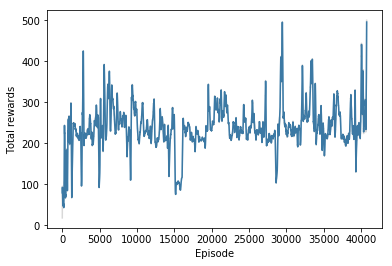

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

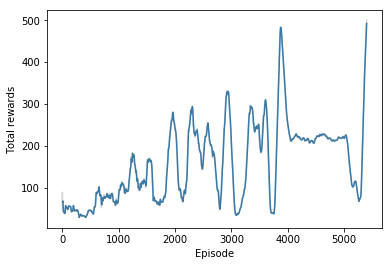

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

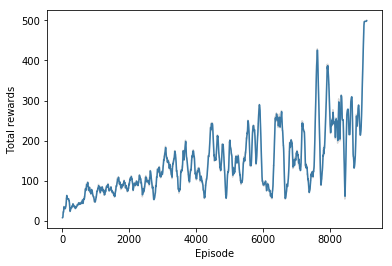

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

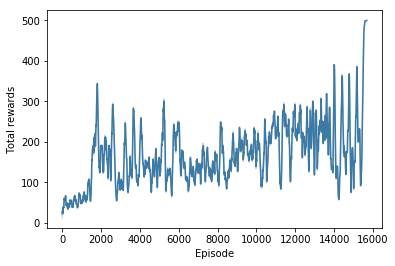

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

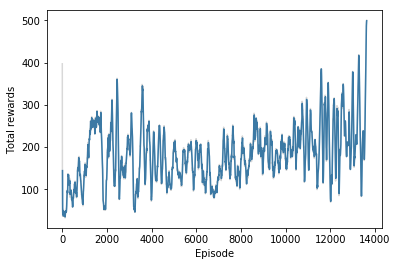

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

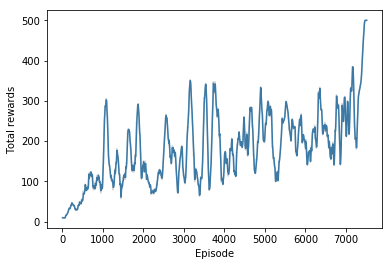

Text(0,0.5,'G losses')

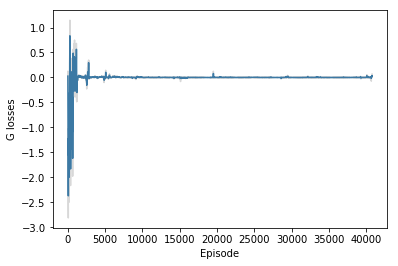

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

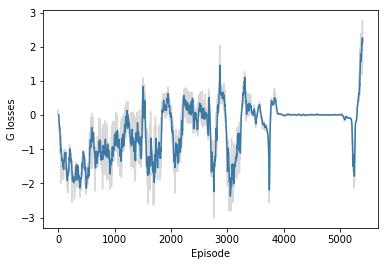

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

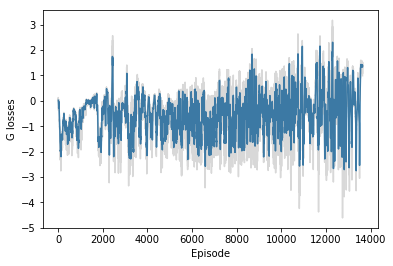

In [33]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'G losses')

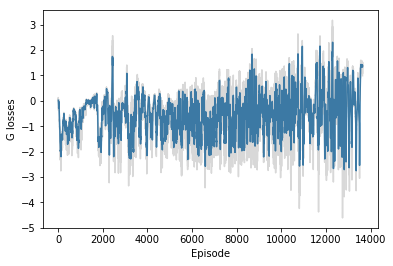

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

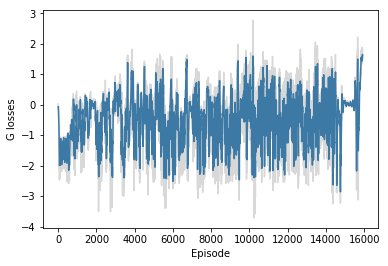
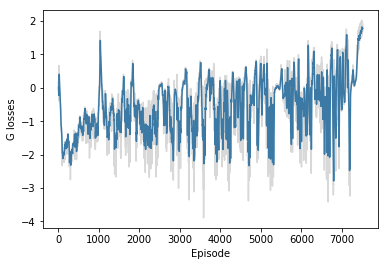

Text(0,0.5,'D losses')

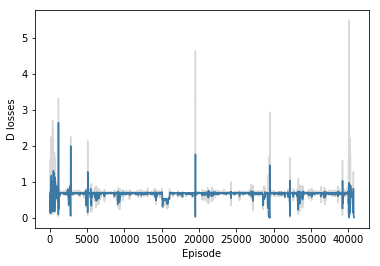

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

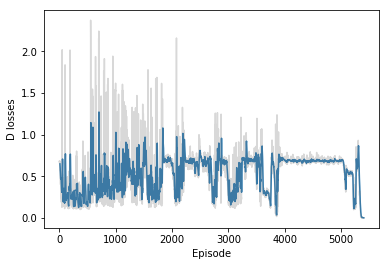

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

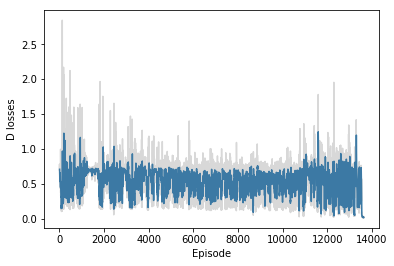

In [34]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses')

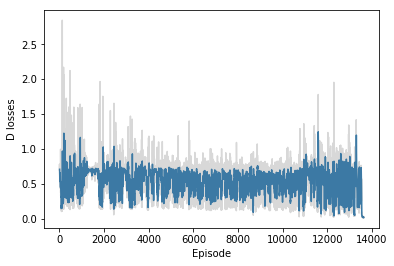

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

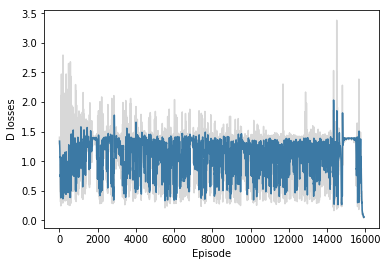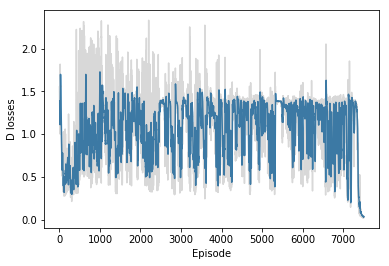

Text(0,0.5,'D losses R')

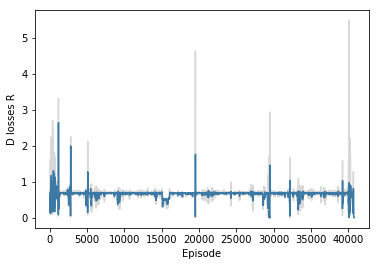

In [57]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

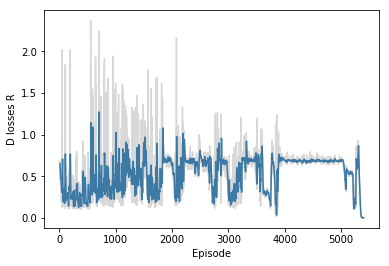

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

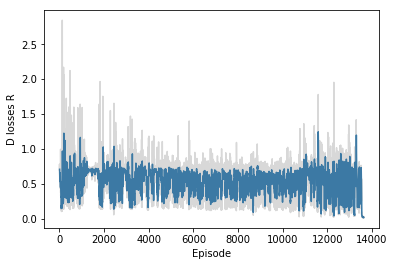

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

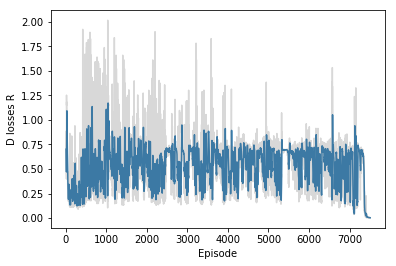

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

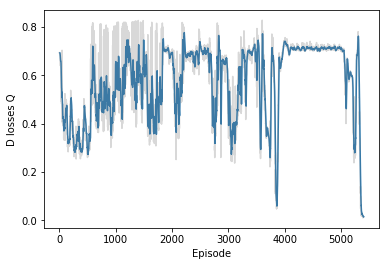

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

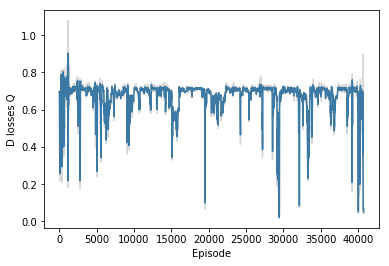

In [58]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

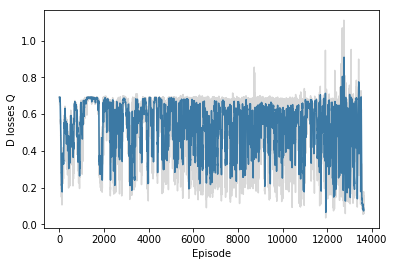

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

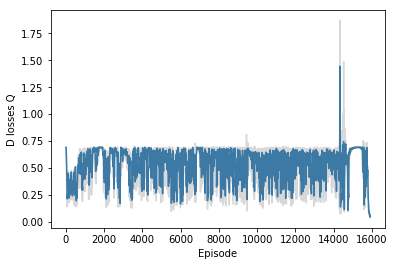

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

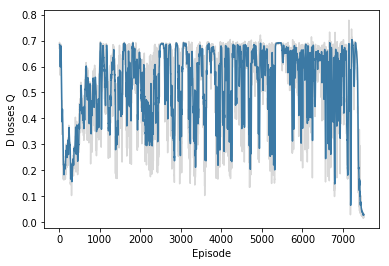

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'Success rates')

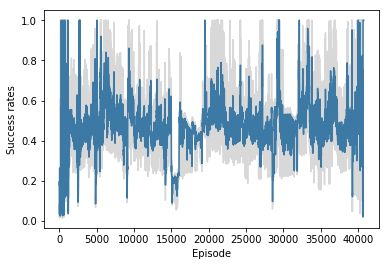

In [59]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.